## SF crime data analysis and modeling

In [2]:
from csv import reader
from pyspark.sql import Row 
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import shapely
from ggplot import *
import warnings
import os
os.environ["PYSPARK_PYTHON"] = "python3"

### Preprocessinng

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("crime analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()
df_opt1 = spark.read.format("csv").option("header", "true").load("/FileStore/tables/sf_data_15_17.csv")

In [5]:
from pyspark.sql.functions import to_timestamp, concat, lit

df_15_17 = df_opt1.select("IncidntNum", "Category", "PdDistrict", "X", "Y", 
                          concat("Date", lit("-"), "Time").alias('Date_time'))
df_15_17 = df_15_17.select("IncidntNum", "Category", "PdDistrict", "X", "Y", 
                          to_timestamp("Date_time", 'MM/dd/yyyy-HH:mm').alias('Date_time'))

In [6]:
df_opt1_2 = spark.read.format("csv").option("header", "true").load("/FileStore/tables/Police_Department_Incident_Reports__2018_to_Present.csv")

In [7]:
from pyspark.sql.functions import upper
df_18 = df_opt1_2.select(df_opt1_2["Incident Number"].alias("IncidntNum"), 
                         upper(df_opt1_2["Incident Category"]).alias("Category"),
                         upper(df_opt1_2["Police District"]).alias("PdDistrict"),
                         df_opt1_2["Longitude"].alias("X"),
                         df_opt1_2["Latitude"].alias("Y"),
                         to_timestamp("Incident Datetime", 'yyyy/MM/dd h:mm:ss a').alias('Date_time'))

In [8]:
df_15_17.printSchema()
df_18.printSchema()

root
-- IncidntNum: string (nullable = true)
-- Category: string (nullable = true)
-- PdDistrict: string (nullable = true)
-- X: string (nullable = true)
-- Y: string (nullable = true)
-- Date_time: timestamp (nullable = true)

root
-- IncidntNum: string (nullable = true)
-- Category: string (nullable = true)
-- PdDistrict: string (nullable = true)
-- X: string (nullable = true)
-- Y: string (nullable = true)
-- Date_time: timestamp (nullable = true)

In [9]:
df = df_15_17.union(df_18)

In [10]:
df = df.select("IncidntNum", "Category", "PdDistrict", df.X.cast("float"), df.Y.cast("float"), "Date_time")
df.printSchema()

root
-- IncidntNum: string (nullable = true)
-- Category: string (nullable = true)
-- PdDistrict: string (nullable = true)
-- X: float (nullable = true)
-- Y: float (nullable = true)
-- Date_time: timestamp (nullable = true)

In [11]:
# Q1_x, Q3_x = df.approxQuantile("X", [0.25, 0.75], 0.0)
# x_min_range = Q1_x - (Q3_x - Q1_x)*1.5
# x_max_range = Q3_x + (Q3_x - Q1_x)*1.5

# Q1_y, Q3_y = df.approxQuantile("Y", [0.25, 0.75], 0.0)
# y_min_range = Q1_y - (Q3_y - Q1_y)*1.5
# y_max_range = Q3_y + (Q3_y - Q1_y)*1.5

# df = df[df["X"] <= max_range]
# df = df[df["X"] >= min_range]
# df = df[df["Y"] <= max_range]
# df = df[df["Y"] >= min_range]

In [12]:
print("Number of rows: ", df.count())
print("Number of NULL in X: ", df.where(df["X"].isNull()).count())
print("Number of NULL in Y: ", df.where(df["Y"].isNull()).count())
print("Number of NULL in Date_time: ", df.where(df["Date_time"].isNull()).count())

Number of rows: 2375297
Number of NULL in X: 8120
Number of NULL in Y: 8120
Number of NULL in Date_time: 0

In [13]:
display(df.groupBy("Category").count().orderBy("Category"))
# df_cat = df.groupBy("Category").count().toPandas()
# print(df_cat.sort_values(by = "count"), "\n")
# print(df_cat.sort_values(by = "Category"))

# display(df.groupBy("Category").agg({"Category":"count"}).orderBy("Category"))

Category,count
null,15
ARSON,4312
ASSAULT,204112
BAD CHECKS,925
BRIBERY,813
BURGLARY,98849
CASE CLOSURE,653
CIVIL SIDEWALKS,522
COURTESY REPORT,420
DISORDERLY CONDUCT,12671


In [14]:
df = df.na.replace(["FAMILY OFFENSES", 
                    "FORGERY AND COUNTERFEITING", 
                    "HUMAN TRAFFICKING, COMMERCIAL SEX ACTS",
                    "LARCENY THEFT",
                    "MOTOR VEHICLE THEFT?",
                    "WARRANT",
                    "WEAPONS OFFENCE"], 
                   ["FAMILY OFFENSE", 
                    "FORGERY/COUNTERFEITING", 
                    "HUMAN TRAFFICKING (A), COMMERCIAL SEX ACTS",
                    "LARCENY/THEFT",
                    "MOTOR VEHICLE THEFT",
                    "WARRANT",
                    "WEAPONS OFFENSE"])
display(df.groupBy("Category").count().orderBy("Category"))

Category,count
null,15
ARSON,4312
ASSAULT,204112
BAD CHECKS,925
BRIBERY,813
BURGLARY,98849
CASE CLOSURE,653
CIVIL SIDEWALKS,522
COURTESY REPORT,420
DISORDERLY CONDUCT,12671


In [15]:
display(df.groupBy("PdDistrict").count().orderBy("PdDistrict"))

PdDistrict,count
null,1
BAYVIEW,233760
CENTRAL,251843
INGLESIDE,205553
MISSION,322216
NORTHERN,292646
OUT OF SF,4054
PARK,133074
RICHMOND,125665
SOUTHERN,420598


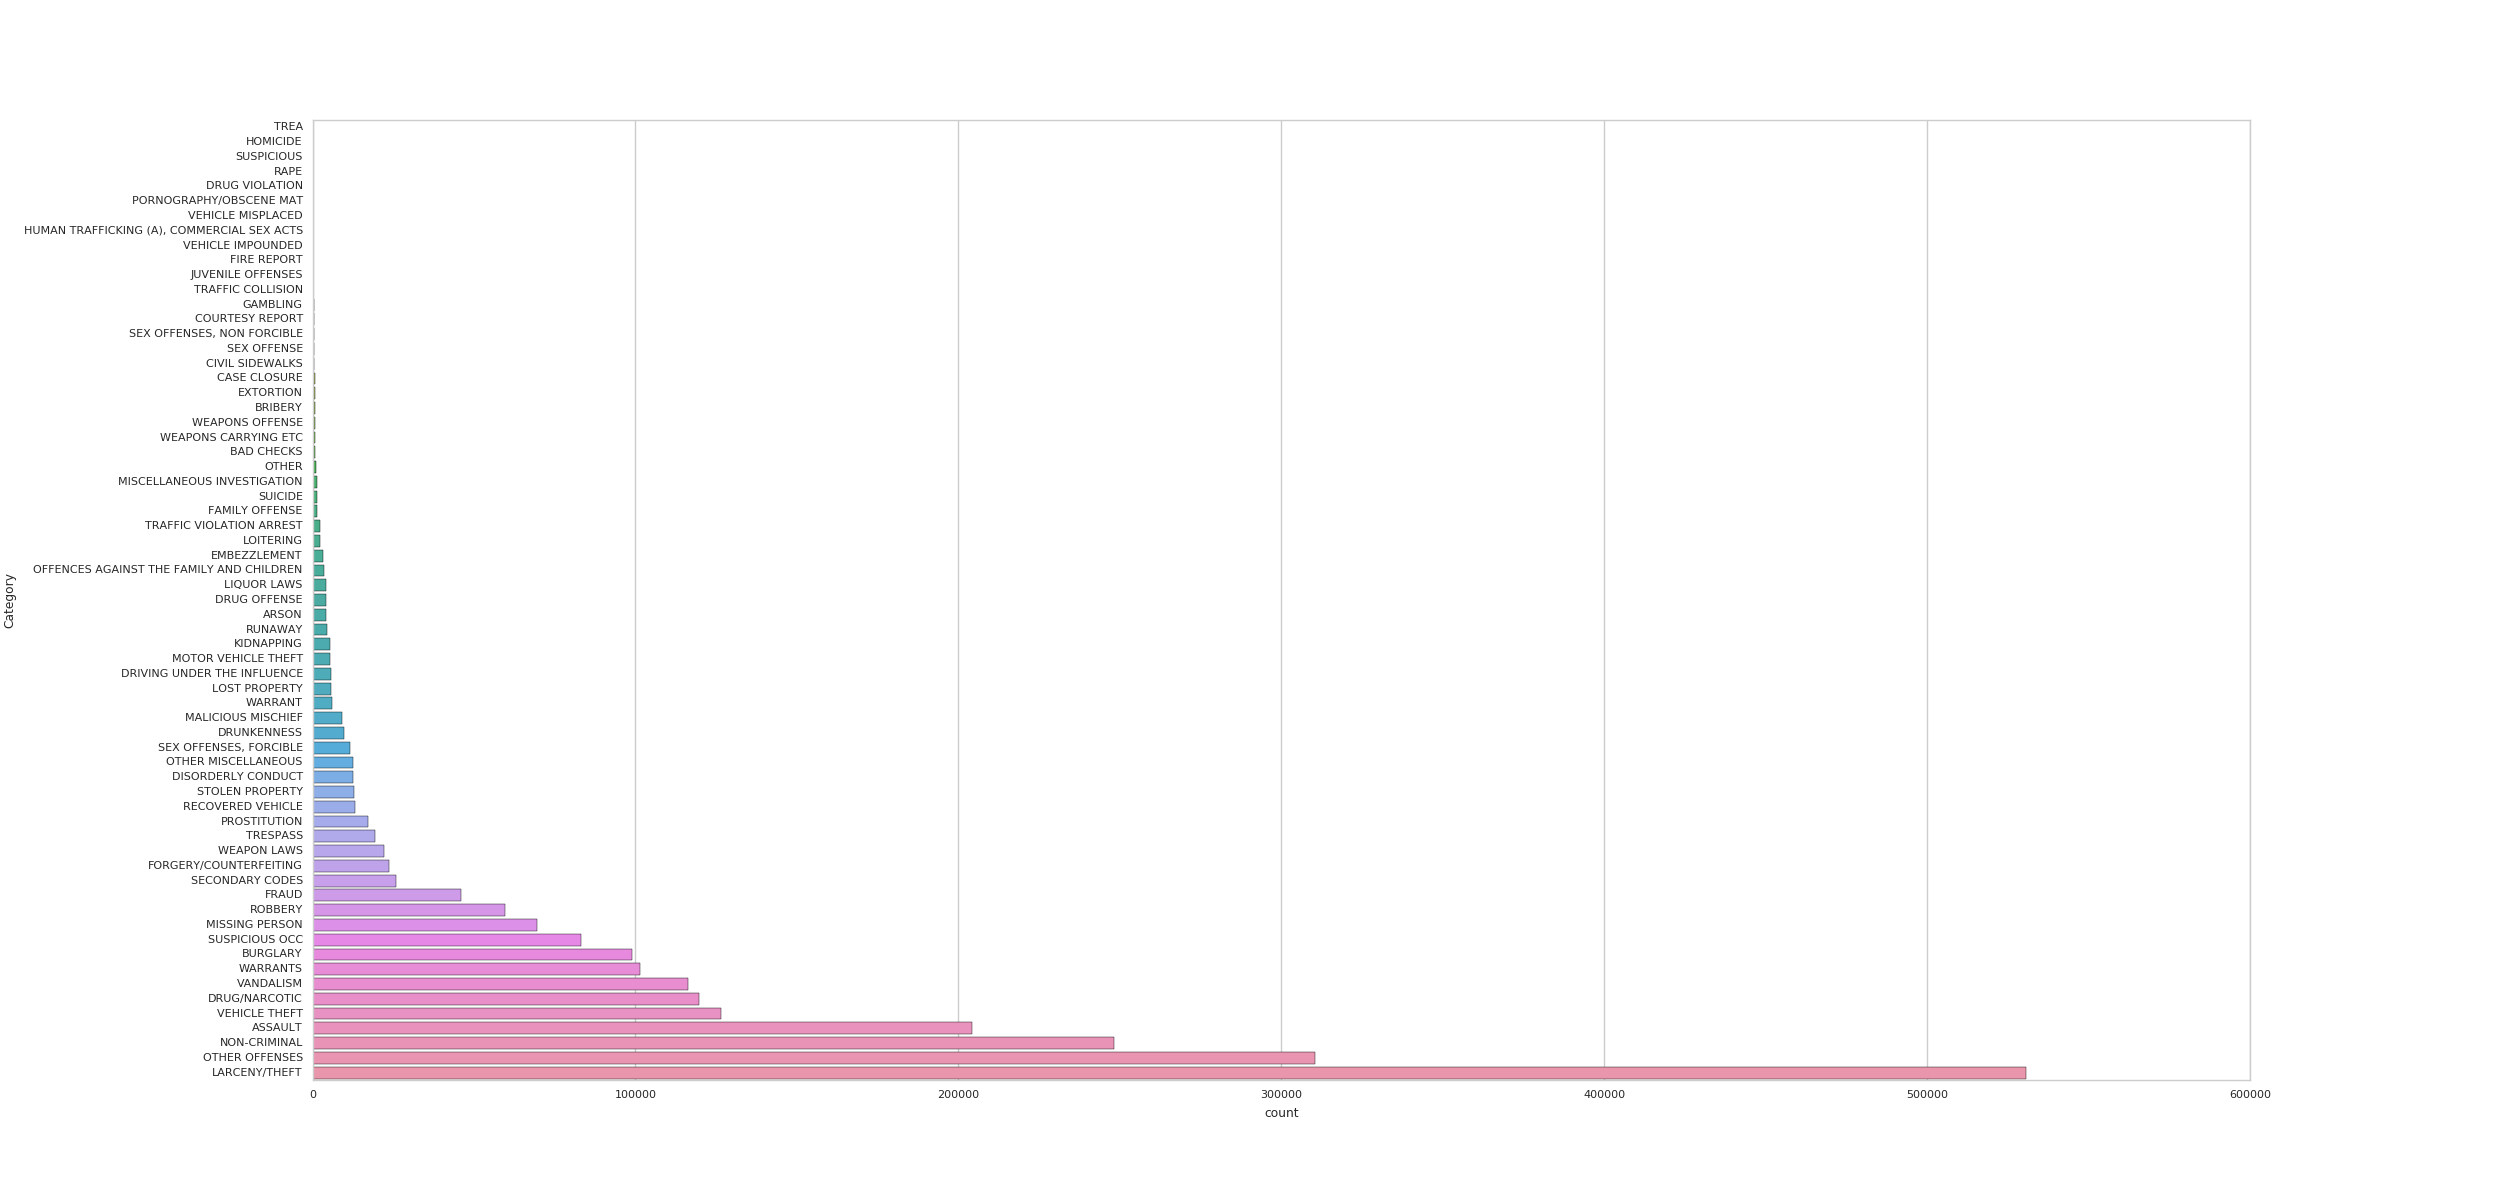

In [16]:
df_X_all = df.groupBy("Category").count().orderBy("count").toPandas()
fig = plt.figure(figsize=(25,12))
sb.set(font_scale=0.8, style = "whitegrid")
sb.barplot(x= "count", y = "Category", data = df_X_all)
plt.legend(loc='upper right')
display(fig)

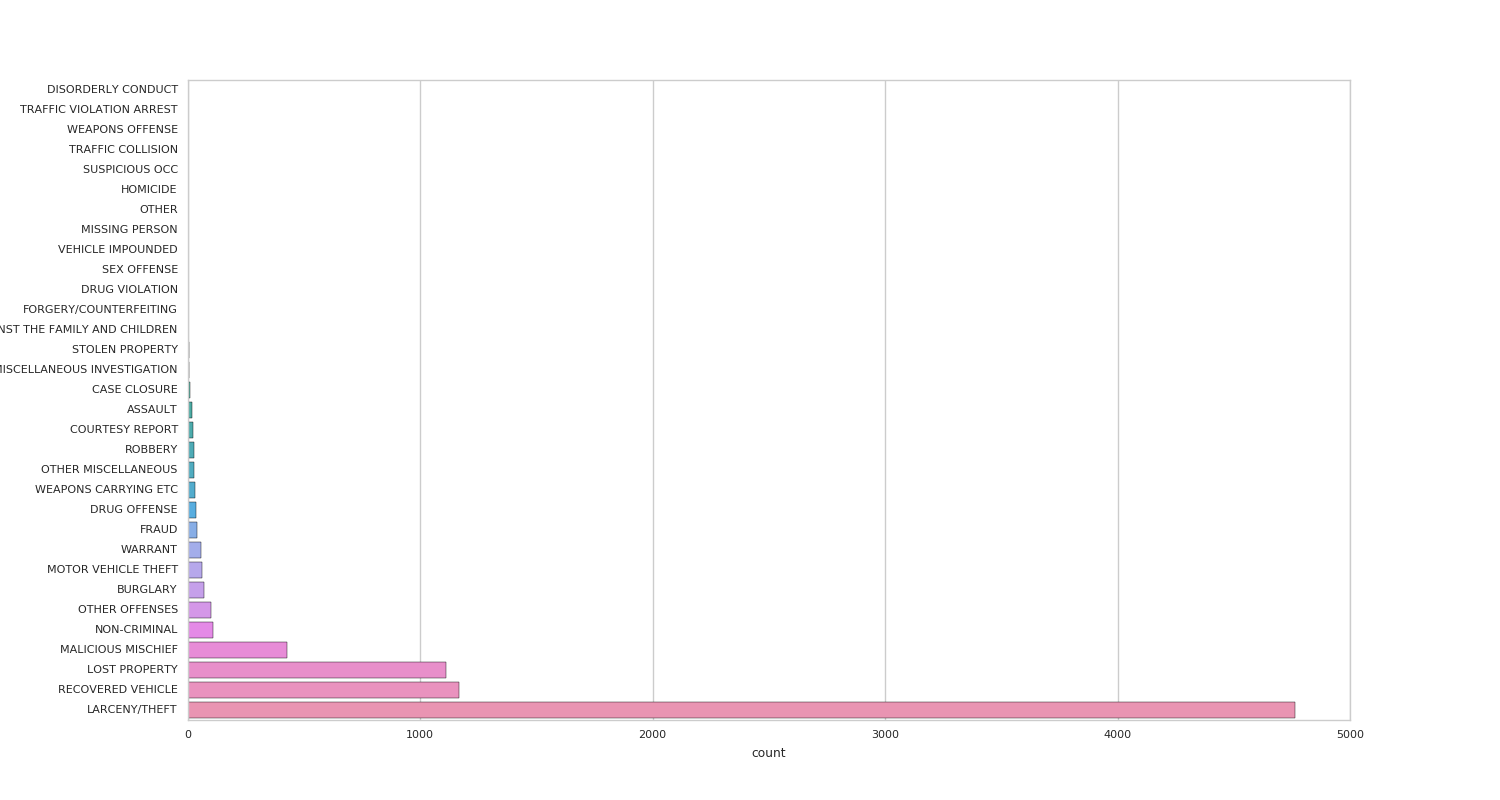

In [17]:
# The original distribution group by each category has similar distribution the null's. Also, it is hard to impute the missing value of cooridinates and hence we delete the whole row if there is any missing value.

df_X_miss = df.where(df["X"].isNull()).groupBy("Category").count().orderBy("count").toPandas()
fig = plt.figure(figsize=(15,8))
sb.set(font_scale=0.8, style = "whitegrid")
sb.barplot(x= "count", y = "Category", data = df_X_miss)
plt.legend(loc='upper right')
display(fig)

In [18]:
df = df.na.drop(how = "any")

In [19]:
df.count()
df.createTempView("sf_crime")

#####Write a Spark program that counts the number of crimes for different category.

In [21]:
#Spark SQL based
crime_cat = spark.sql("SELECT category, COUNT(IncidntNum) AS Numbers_Crime \
                       FROM sf_crime \
                       GROUP BY category \
                       ORDER BY Numbers_Crime DESC")
display(crime_cat)
crime_cat = crime_cat.toPandas()

category,Numbers_Crime
LARCENY/THEFT,525911
OTHER OFFENSES,310437
NON-CRIMINAL,248226
ASSAULT,204094
VEHICLE THEFT,126602
DRUG/NARCOTIC,119628
VANDALISM,116244
WARRANTS,101379
BURGLARY,98777
SUSPICIOUS OCC,83251


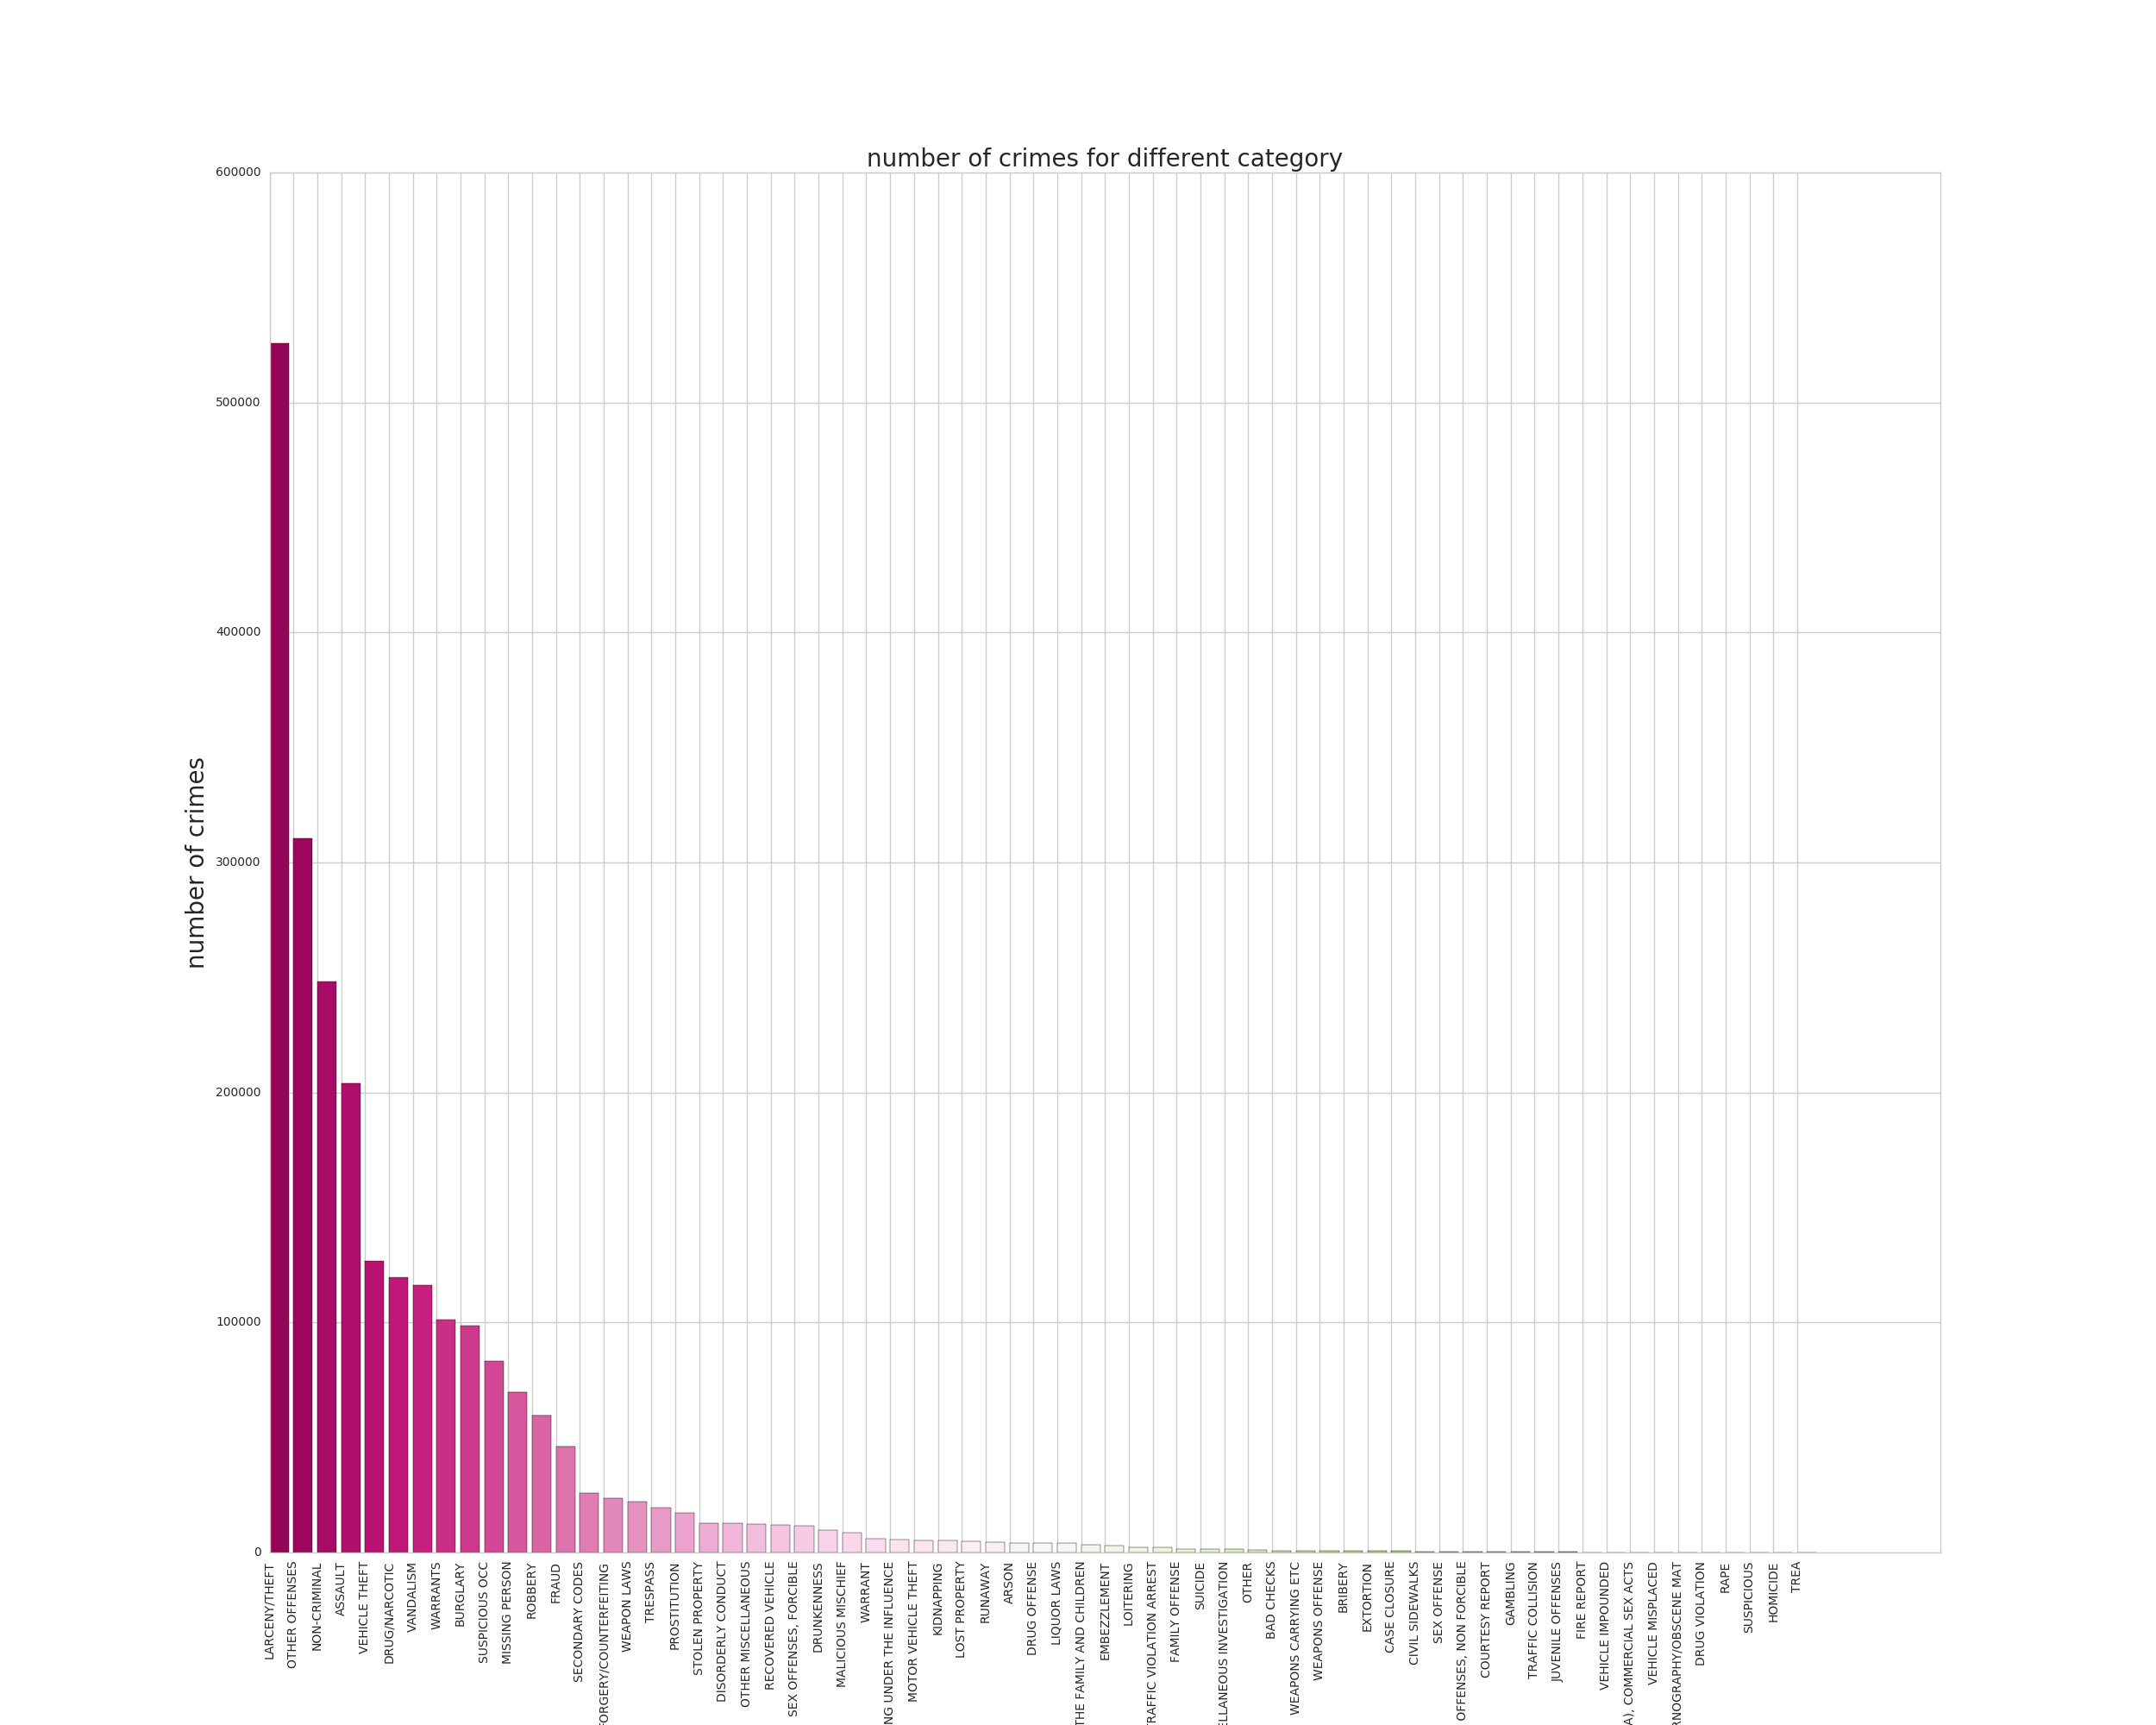

In [22]:
sb.set(style = "whitegrid")
fig = plt.figure(figsize=(25,20))
x = np.arange(len(crime_cat["category"]))
plt.bar(x, crime_cat["Numbers_Crime"], color = sb.color_palette("PiYG", len(x)), data = crime_cat)
plt.ylabel("number of crimes", fontsize=20)
plt.xticks(x, tuple(crime_cat["category"]), fontsize = 10, rotation = 90)
plt.title('number of crimes for different category', fontsize=20)
display(fig)

#### Counts the number of crimes for different district, and visualize your results

In [24]:
df_district = spark.sql("SELECT PdDistrict, COUNT(*) as Numbers_Crime \
                         FROM sf_crime \
                         GROUP BY PdDistrict \
                         ORDER BY Numbers_Crime DESC")
display(df_district)
df_district = df_district.toPandas()

PdDistrict,Numbers_Crime
SOUTHERN,419377
MISSION,321565
NORTHERN,292062
CENTRAL,250604
BAYVIEW,233528
TENDERLOIN,207492
INGLESIDE,205430
TARAVAL,177957
PARK,132737
RICHMOND,124927


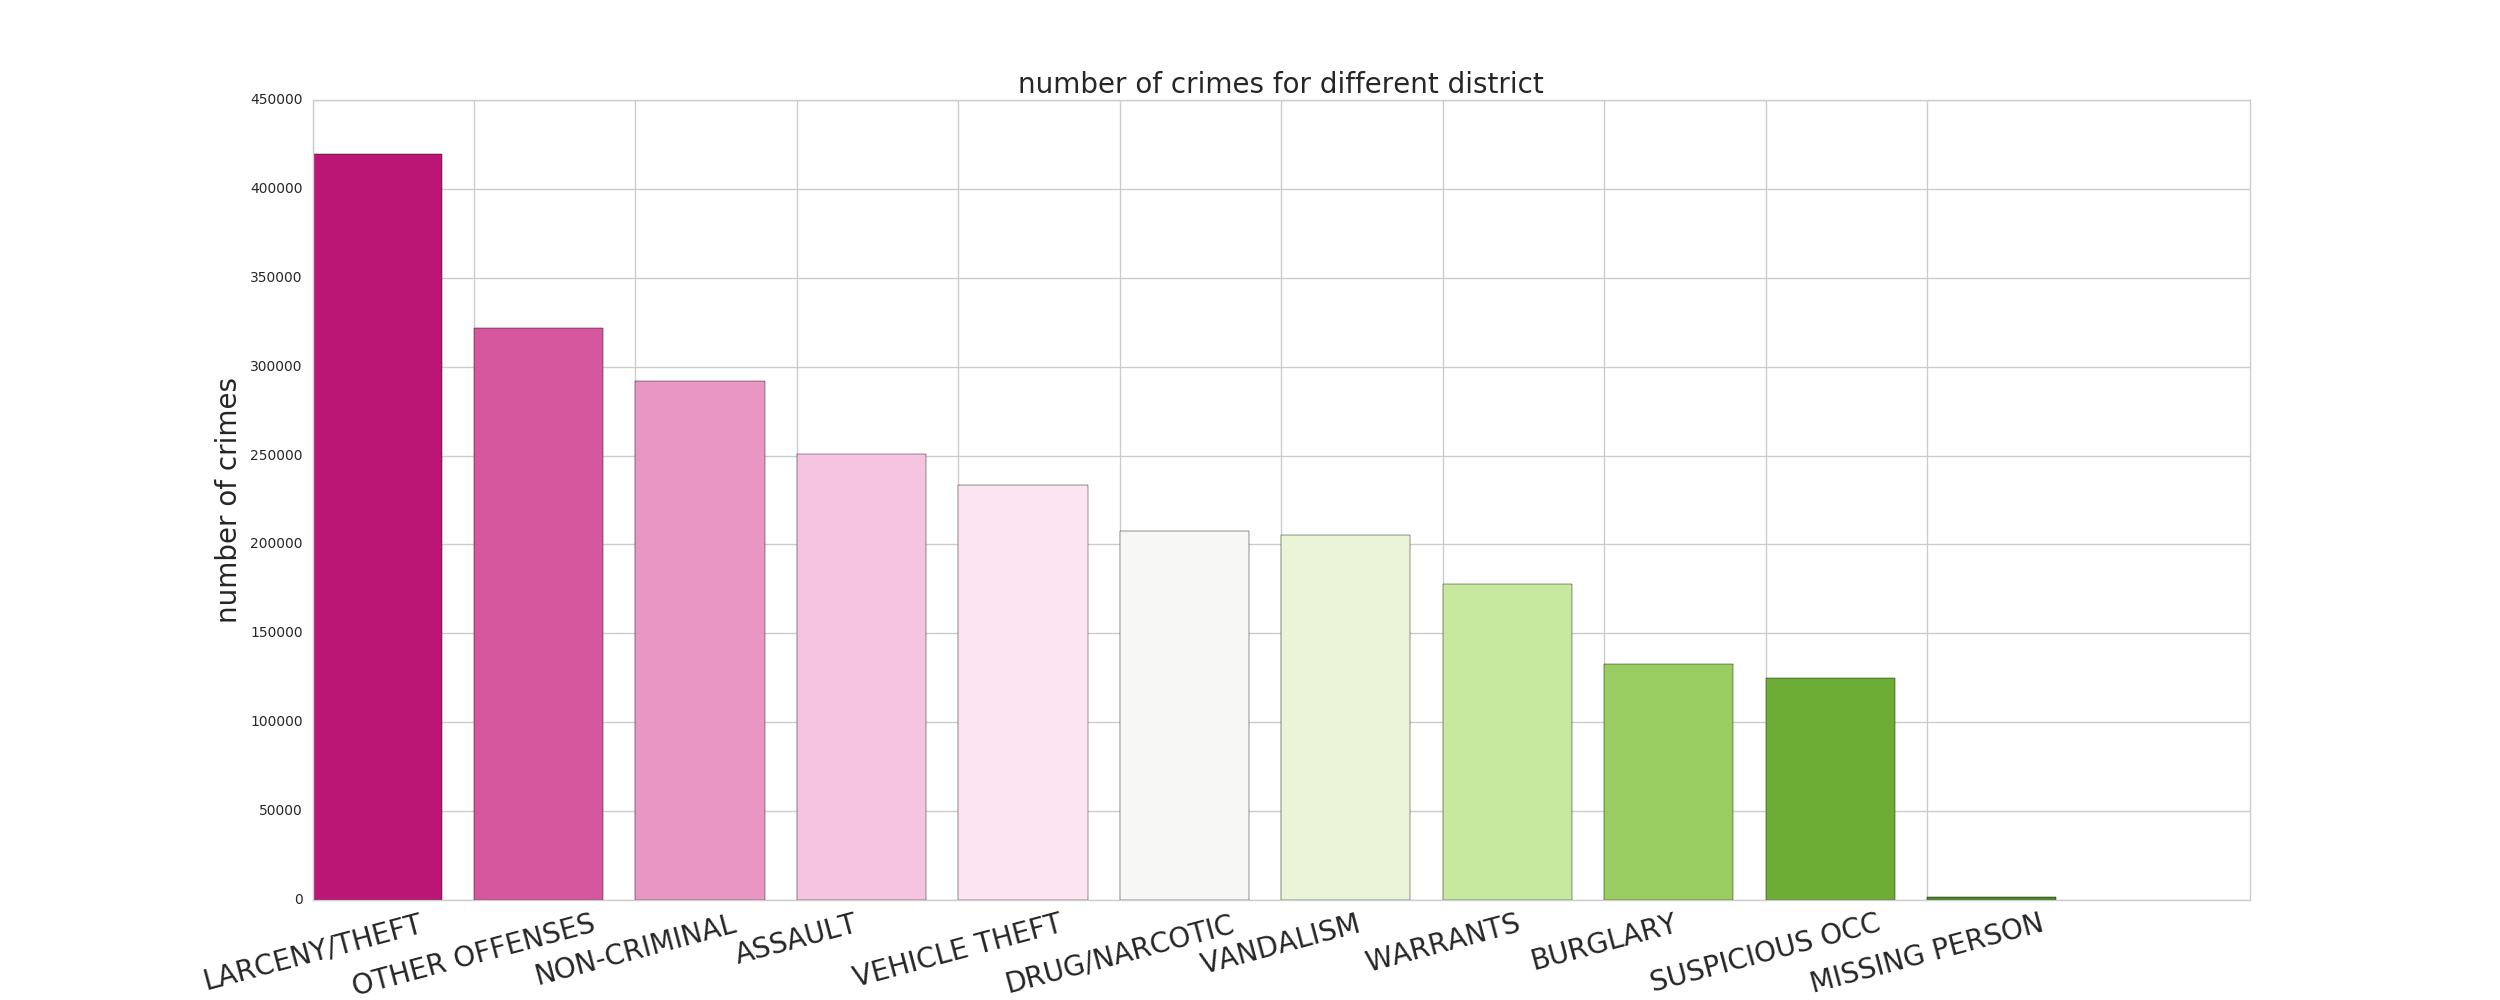

In [25]:
sb.set(style = "whitegrid")
fig = plt.figure(figsize=(25,10))
x = np.arange(len(df_district["PdDistrict"]))
plt.bar(x, df_district["Numbers_Crime"], color = sb.color_palette("PiYG", len(x)), data = df_district)
plt.ylabel("number of crimes", fontsize=20)
plt.xticks(x, tuple(crime_cat["category"]), fontsize = 20, rotation = 15)
plt.title('number of crimes for different district', fontsize=20)
display(fig)

#### Count the number of crimes each "Sunday" at "SF downtown".

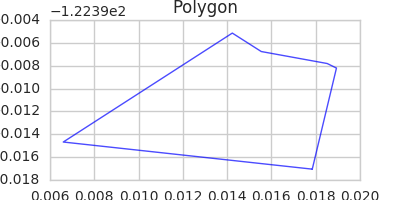

In [27]:
# draw the plot according to the coordinates from Google map to make sure the region of the polygon is correct

from pyspark.sql.types import FloatType, BooleanType
from pyspark.sql.functions import udf
from shapely.geometry import Polygon, Point
poly = Polygon([(37.797844, -122.407050), (37.798937, -122.398205), (37.798519, -122.397808), 
              (37.795541, -122.396759), (37.794233, -122.395145), (37.786599, -122.404677),
              (37.797844, -122.407050)])  # this is when I know the order of the coordinates

x,y = poly.exterior.xy
fig = plt.figure(figsize=(4,2))
ax = fig.add_subplot(111)
ax.plot(x, y, color='blue', alpha=0.7, linewidth=1)
ax.set_title('Polygon')
display(fig)

In [28]:
# UDF: return true if the crime is in SF downtown area

def in_sf_downtown(x,y):
  point = Point(float(y), float(x))
  return poly.contains(point)


sf_downtown_udf = udf(lambda x, y: in_sf_downtown(x,y), StringType())
#point = (37.792457, -122.404677)
#in_sf_downtown(point)
#print(type(point[0]))

In [29]:
from pyspark.sql.functions import to_timestamp, to_date
df_Q3 = df.select(["IncidntNum", "X", "Y", sf_downtown_udf("X","Y").alias('In_downtown'), to_date("Date_time").alias('Date')])
df_Q3.createOrReplaceTempView("sf_crime_Q3")

In [30]:
df_crime_sunday = spark.sql("SELECT *\
                             FROM sf_crime_Q3 \
                             WHERE WEEKDAY(Date) = 6 and In_downtown = true")
# display(df_crime_sunday)
# df_crime_sunday.show(truncate = False)
# df = df_crime_sunday.toPandas()
# df["In_downtown"].value_counts()

#### Analysis the number of crime in each month of 2015, 2016, 2017, 2018. Then, give your insights for the output results. What is the business impact for your result?

In [32]:
df_crime_month = spark.sql("SELECT YEAR(Date_time) AS Year, MONTH(Date_time) AS Month, COUNT(*) AS Numbers_Crime\
                            FROM sf_crime\
                            GROUP BY MONTH(Date_time), YEAR(Date_time)\
                            ORDER BY YEAR(Date_time), MONTH(Date_time)")
display(df_crime_month)
df_crime_month = df_crime_month.toPandas()
df_crime_month
# df_crime_month["Year"] = df_crime_month["Year"].astype(str)
# df_crime_month["Month"] = df_crime_month["Month"].astype(str)
# df_crime_month.info()
# pd.pivot_table(data = df_crime_month, values=Numbers_Crime, index=Year, columns=Month, aggfunc='sum')

Year,Month,Numbers_Crime
2003,1,12956
2003,2,11924
2003,3,12998
2003,4,12741
2003,5,12605
2003,6,11934
2003,7,12379
2003,8,12893
2003,9,12798
2003,10,13050


In [33]:
for i in range(2003,2020):
  print(df_crime_month[df_crime_month["Year"] == i]["Month"])

Year Month Numbers_Crime
0 2003 1 12956
1 2003 2 11924
2 2003 3 12998
3 2003 4 12741
4 2003 5 12605
5 2003 6 11934
6 2003 7 12379
7 2003 8 12893
8 2003 9 12798
9 2003 10 13050
10 2003 11 11827
11 2003 12 11071
 Year Month Numbers_Crime
12 2004 1 13086
13 2004 2 11933
14 2004 3 13143
15 2004 4 12765
16 2004 5 13360
17 2004 6 12210
18 2004 7 12578
19 2004 8 12487
20 2004 9 11795
21 2004 10 12203
22 2004 11 11049
23 2004 12 11539
 Year Month Numbers_Crime
24 2005 1 12340
25 2005 2 10691
26 2005 3 12189
27 2005 4 12001
28 2005 5 12302
29 2005 6 11631
30 2005 7 11907
31 2005 8 12141
32 2005 9 11689
33 2005 10 12721
34 2005 11 11594
35 2005 12 10980
 Year Month Numbers_Crime
36 2006 1 11833
37 2006 2 10772
38 2006 3 11676
39 2006 4 11563
40 2006 5 11457
41 2006 6 11657
42 2006 7 11693
43 2006 8 12518
44 2006 9 11420
45 2006 10 11781
46 2006 11 10791
47 2006 12 10692
 Year Month Numbers_Crime
48 2007 1 11601
49 2007 2 10513
50 2007 3 11906
51 2007 4 10995
52 2007 5 11378
53 2007 6 11050
54 2007 7 11838
55 2007 8 11783
56 2007 9 11969
57 2007 10 12122
58 2007 11 11598
59 2007 12 10886
 Year Month Numbers_Crime
60 2008 1 11984
61 2008 2 11041
62 2008 3 12435
63 2008 4 11358
64 2008 5 11881
65 2008 6 10715
66 2008 7 12308
67 2008 8 11420
68 2008 9 12106
69 2008 10 12941
70 2008 11 11948
71 2008 12 11174
 Year Month Numbers_Crime
72 2009 1 11929
73 2009 2 10722
74 2009 3 12663
75 2009 4 12094
76 2009 5 11364
77 2009 6 10359
78 2009 7 11420
79 2009 8 12965
80 2009 9 12356
81 2009 10 11994
82 2009 11 11350
83 2009 12 10644
 Year Month Numbers_Crime
84 2010 1 11370
85 2010 2 10240
86 2010 3 11131
87 2010 4 10486
88 2010 5 11573
89 2010 6 10855
90 2010 7 10946
91 2010 8 11646
92 2010 9 11792
93 2010 10 11907
94 2010 11 10808
95 2010 12 10769
 Year Month Numbers_Crime
96 2011 1 11634
97 2011 2 9983
98 2011 3 11397
99 2011 4 11230
100 2011 5 11451
101 2011 6 10995
102 2011 7 10744
103 2011 8 11075
104 2011 9 11257
105 2011 10 11445
106 2011 11 10554
107 2011 12 10932
 Year Month Numbers_Crime
108 2012 1 11629
109 2012 2 10929
110 2012 3 11457
111 2012 4 11258
112 2012 5 11813
113 2012 6 11063
114 2012 7 11508
115 2012 8 12333
116 2012 9 11910
117 2012 10 13187
118 2012 11 12018
119 2012 12 11742
 Year Month Numbers_Crime
120 2013 1 12757
121 2013 2 11732
122 2013 3 12938
123 2013 4 12456
124 2013 5 12877
125 2013 6 12371
126 2013 7 13033
127 2013 8 13610
128 2013 9 13725
129 2013 10 13848
130 2013 11 12217
131 2013 12 11242
 Year Month Numbers_Crime
132 2014 1 12777
133 2014 2 11565
134 2014 3 12887
135 2014 4 12353
136 2014 5 12314
137 2014 6 11901
138 2014 7 12741
139 2014 8 13435
140 2014 9 12541
141 2014 10 13381
142 2014 11 12120
143 2014 12 12113
 Year Month Numbers_Crime
144 2015 1 13606
145 2015 2 12329
146 2015 3 13929
147 2015 4 12959
148 2015 5 13729
149 2015 6 13304
150 2015 7 13365
151 2015 8 13730
152 2015 9 12896
153 2015 10 13147
154 2015 11 12091
155 2015 12 11441
 Year Month Numbers_Crime
156 2016 1 12966
157 2016 2 12106
158 2016 3 12380
159 2016 4 12328
160 2016 5 12732
161 2016 6 12094
162 2016 7 12191
163 2016 8 12471
164 2016 9 12499
165 2016 10 13388
166 2016 11 12720
167 2016 12 13007
 Year Month Numbers_Crime
168 2017 1 13084
169 2017 2 12192
170 2017 3 13711
171 2017 4 12941
172 2017 5 13267
173 2017 6 12605
174 2017 7 13171
175 2017 8 12872
176 2017 9 12684
177 2017 10 13355
178 2017 11 12347
179 2017 12 12544
 Year Month Numbers_Crime
180 2018 1 24731
181 2018 2 21300
182 2018 3 22815
183 2018 4 22307
184 2018 5 16068
185 2018 6 11901
186 2018 7 13242
187 2018 8 13208
188 2018 9 12241
189 2018 10 12666
190 2018 11 11426
191 2018 12 11456
 Year Month Numbers_Crime
192 2019 1 5445

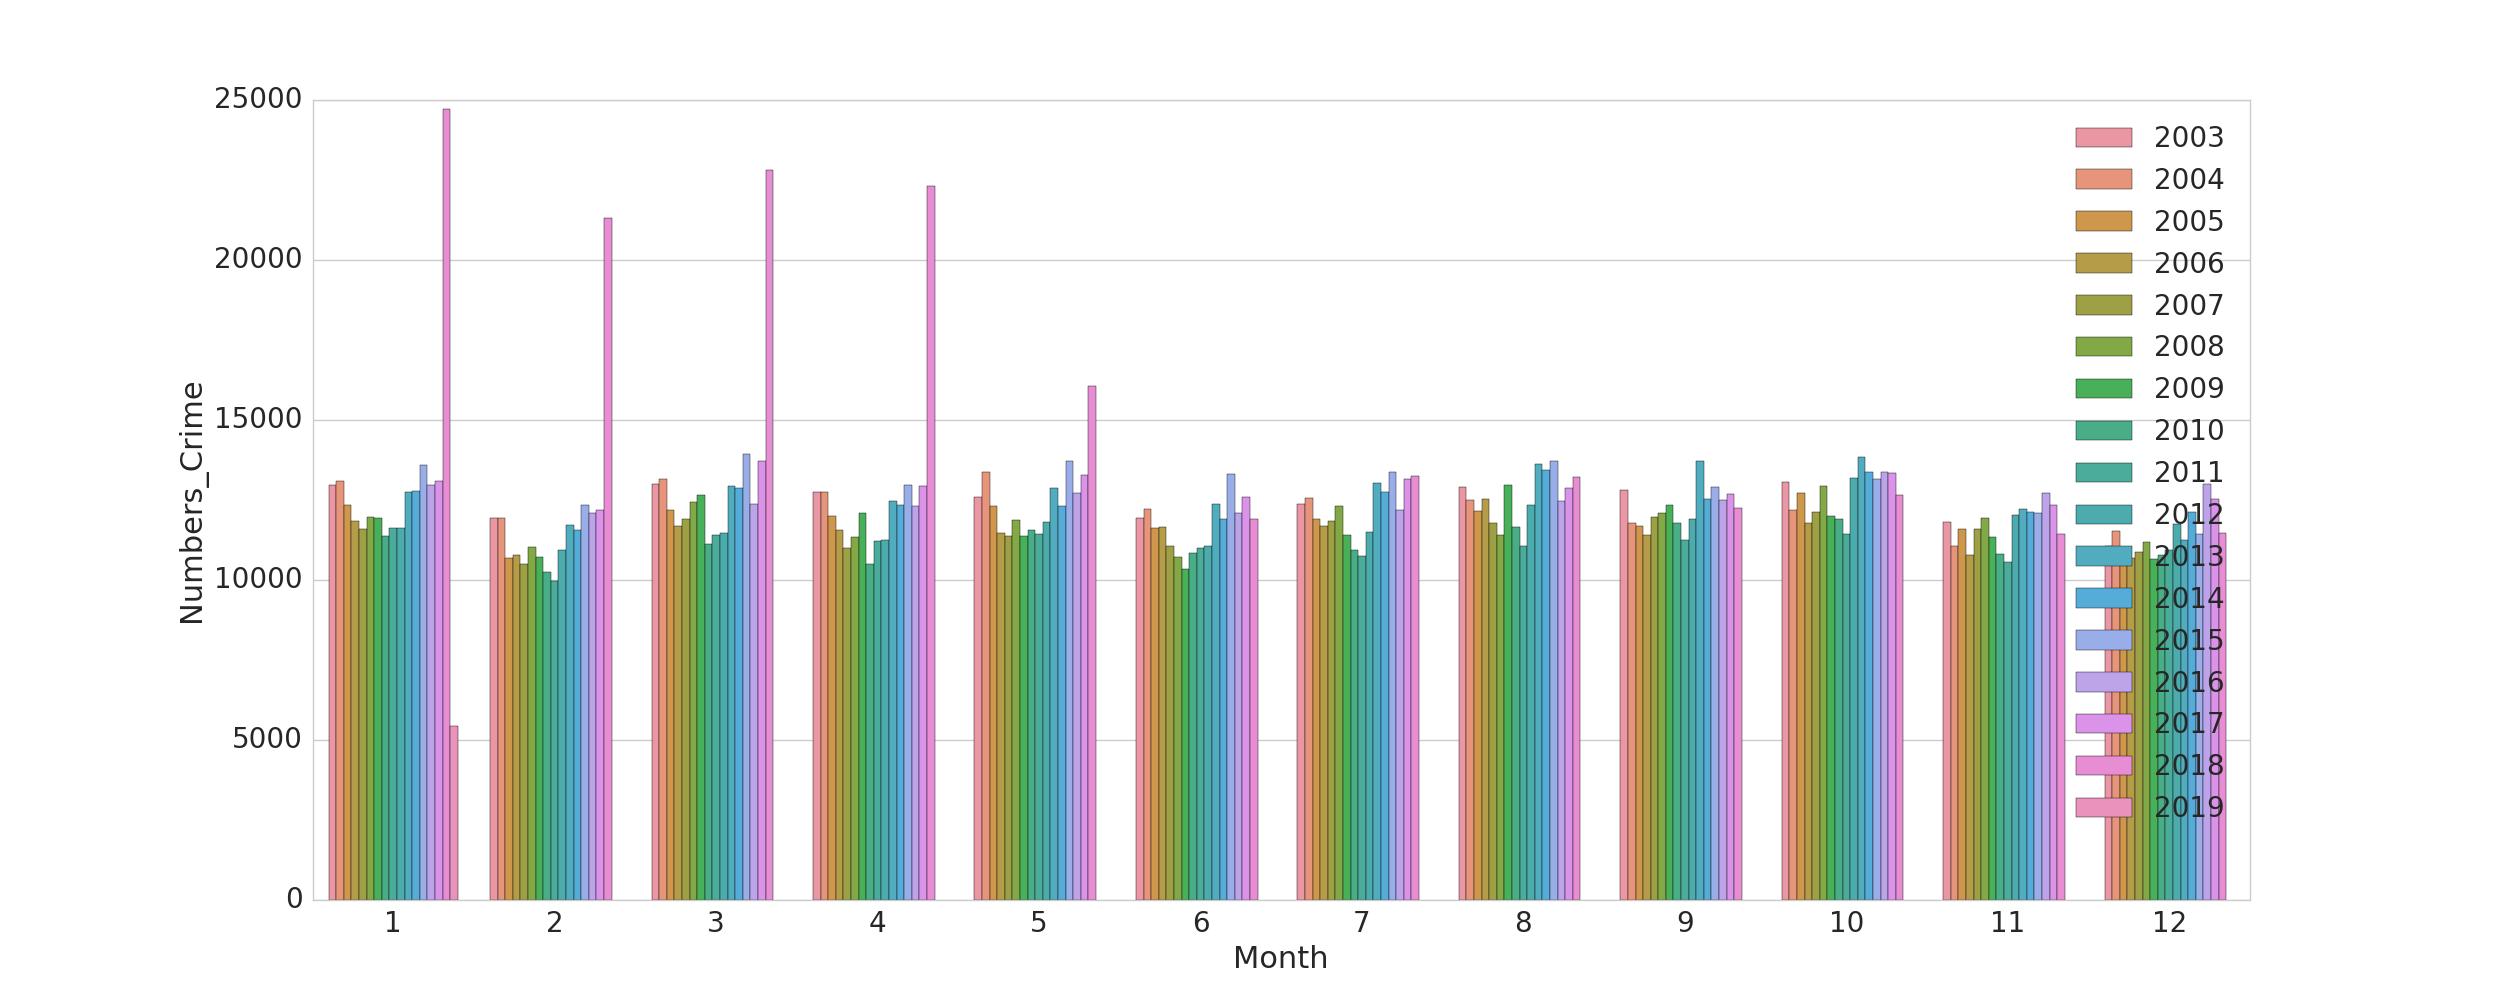

In [34]:
fig = plt.figure(figsize=(25,10))
sb.set(font_scale=2, style = "whitegrid", rc={"lines.linewidth": 2.5})
sb.barplot(x= "Month", y = "Numbers_Crime", hue="Year", data = df_crime_month)
plt.legend(loc='upper right')
display(fig)

##### What is the business impact for your result?

Except for the first half year of 2018, there is no big difference between the number of crimes bewteen each year. In the year of 2018, the police seemed experimenting some new method because the crime was decreasing overall(exclude demcember due to imcomplete of the data) and the new method seemd to worked. We may invest more on the new method.

#### Q5 question (OLAP)
Analysis the number of crime w.r.t the hour in certian day like 2015/12/15, 2016/12/15, 2017/12/15, 2018/10/15. Then, give your travel suggestion to visit SF.

In [37]:
df_crime_same_date = spark.sql("SELECT YEAR(Date_time) AS Year, DATE(Date_time) AS Date, HOUR(Date_time) AS Hour, COUNT(*) AS Numbers_Crime\
                                FROM sf_crime\
                                WHERE DATE(Date_time) in ('2015-12-15','2016-12-15', '2017-12-15', '2018-12-15')\
                                GROUP BY HOUR(Date_time), DATE(Date_time), YEAR(Date_time)\
                                ORDER BY YEAR(Date_time), DATE(Date_time), HOUR(Date_time)")

display(df_crime_same_date)
df_crime_same_date = df_crime_same_date.toPandas()

Year,Date,Hour,Numbers_Crime
2015,2015-12-15,0,15
2015,2015-12-15,1,6
2015,2015-12-15,2,5
2015,2015-12-15,3,4
2015,2015-12-15,4,10
2015,2015-12-15,5,3
2015,2015-12-15,6,4
2015,2015-12-15,7,8
2015,2015-12-15,8,12
2015,2015-12-15,9,10


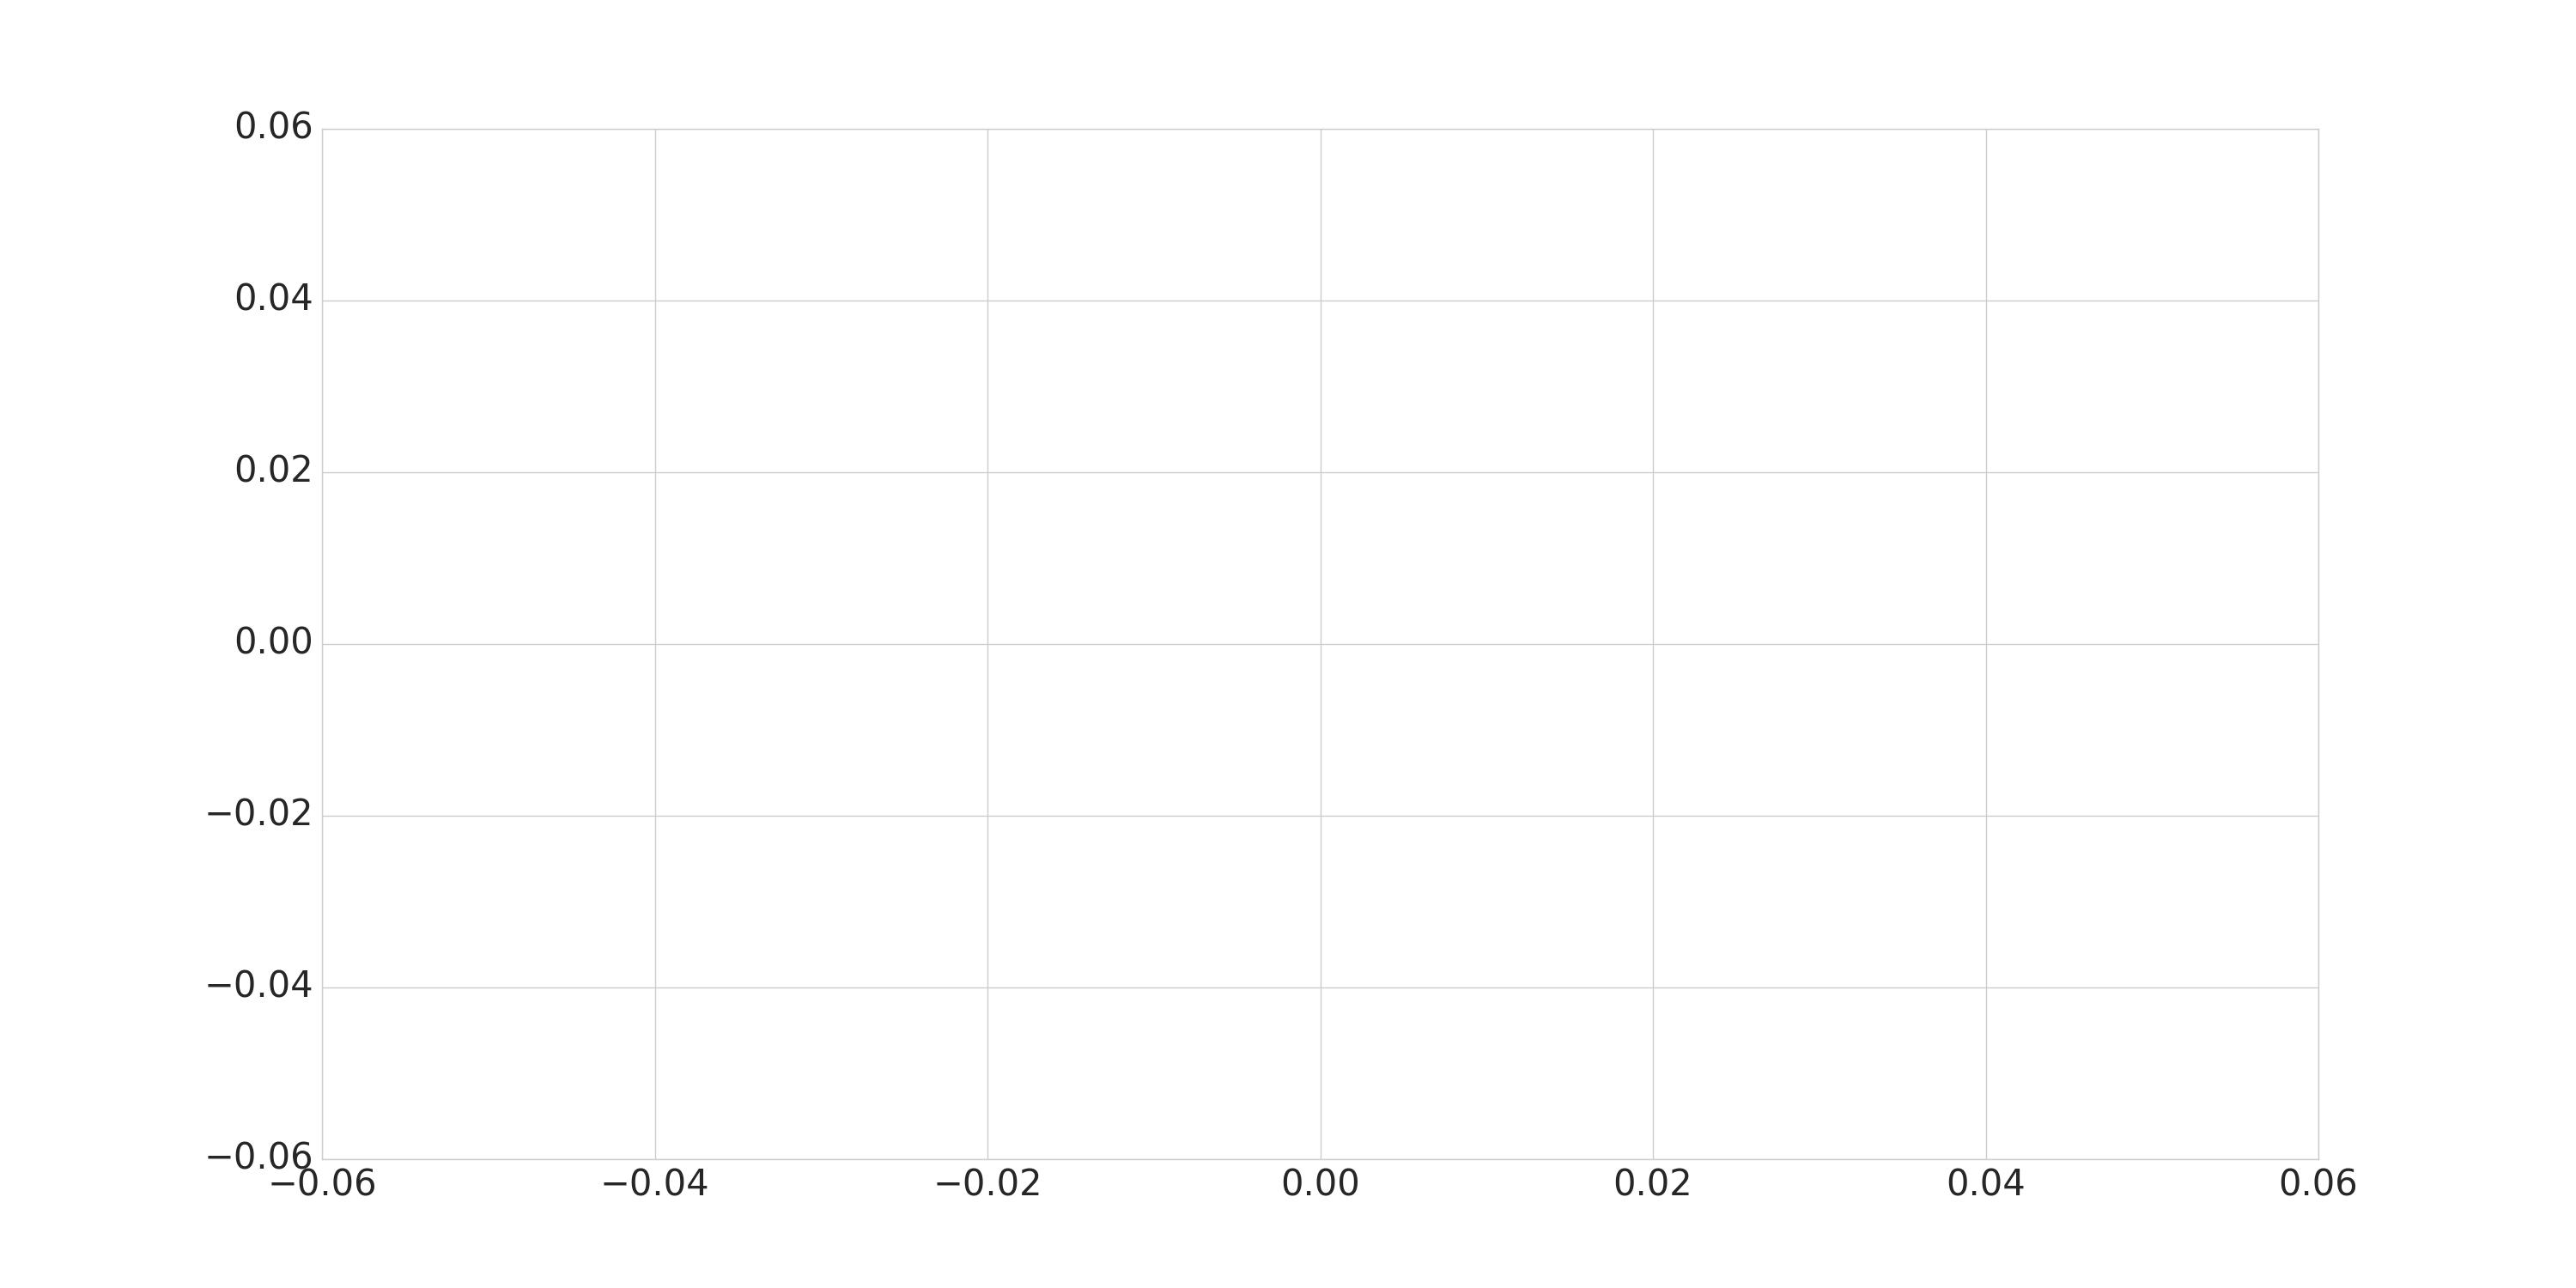

In [38]:
fig = plt.figure(figsize=(30,15))
plt.stackplot(df_crime_same_date[df_crime_same_date["Date"] == "2015-12-15"]["Hour"].values, 
              df_crime_same_date[df_crime_same_date["Date"] == "2015-12-15"]["Numbers_Crime"].values, colors = "red", alpha = 1)
display(fig)

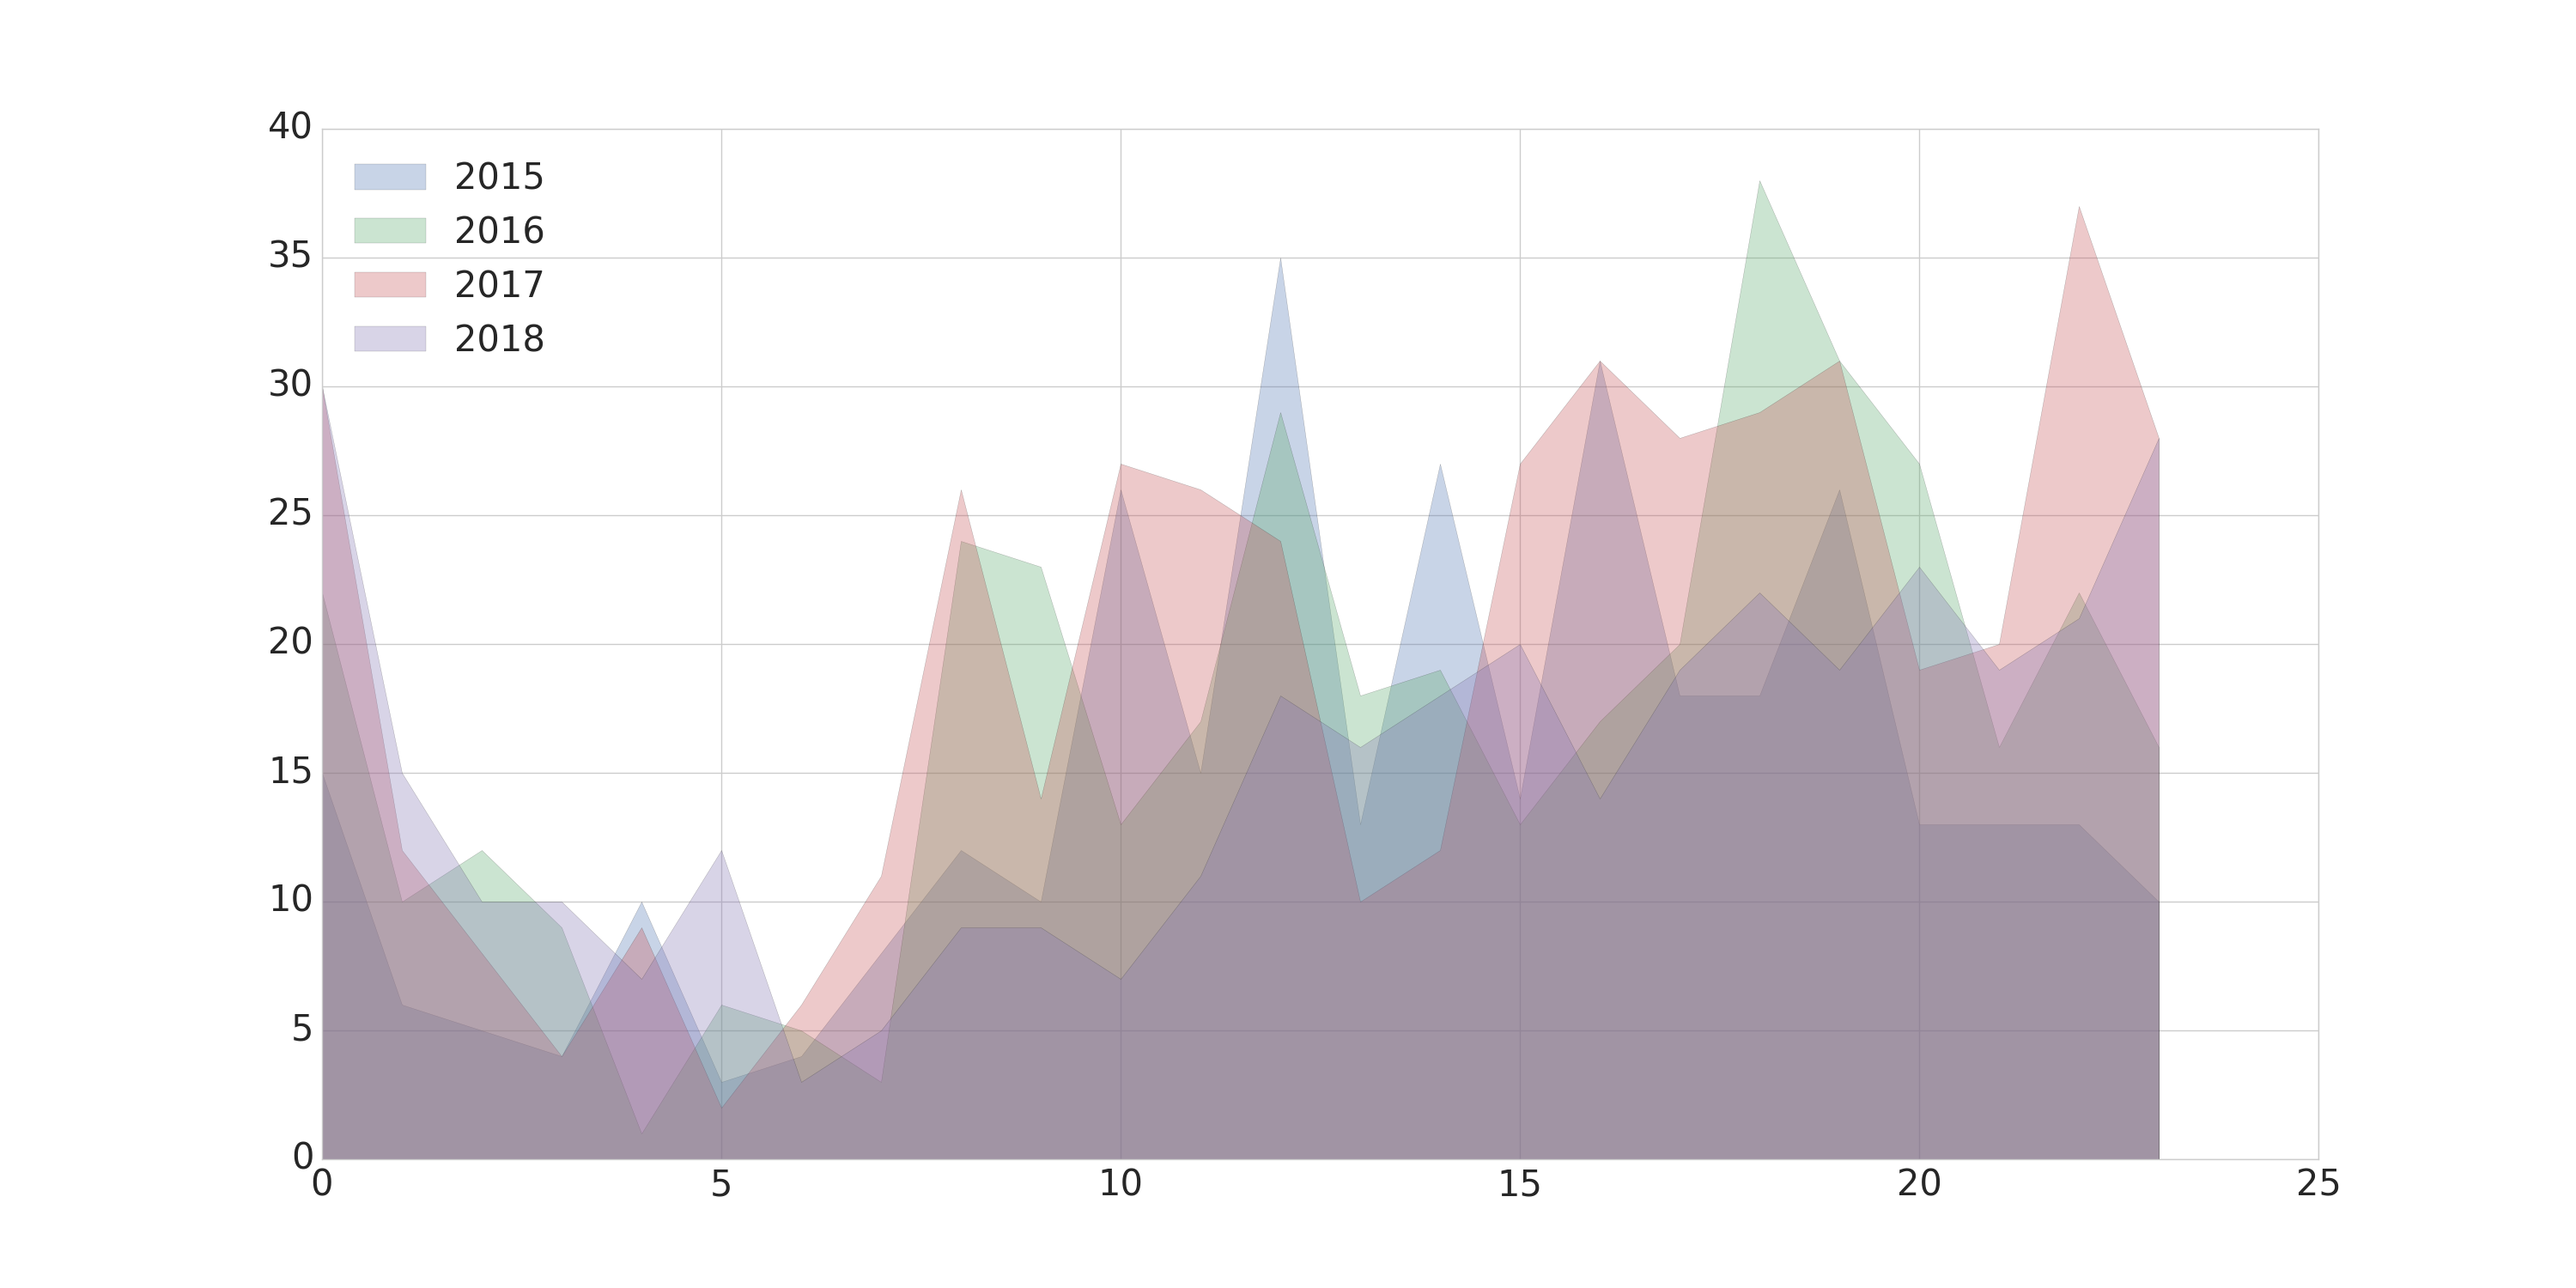

In [39]:
fig = plt.figure(figsize=(30,15))
sb.set(font_scale=3, style = "whitegrid", rc={"lines.linewidth": 4.5})

for day in df_crime_same_date["Date"].unique():
  plt.stackplot(df_crime_same_date[df_crime_same_date["Date"] == day]["Hour"],
                df_crime_same_date[df_crime_same_date["Date"] == day]["Numbers_Crime"] , alpha=0.3)

plt.legend([2015, 2016, 2017, 2018], loc='upper left')
display(fig)

##### give your travel suggestion to visit SF

Visitors should pay more attention after 8 a.m. because the number of crimes surge up after that time and decrease again after 1 a.m.. Also, visitors should be extremely careful during lunch time and dinner time because it is having highest number of crimes during theses two periods.

#### Q6 question (OLAP)
(1) Step1: Find out the top-3 danger disrict  
(2) Step2: find out the crime event w.r.t category and time (hour) from the result of step 1  
(3) give your advice to distribute the police based on your analysis results.

In [42]:
df_crime_danger_dist = spark.sql("SELECT PdDistrict, COUNT(*) AS Numbers_Crime \
                                  FROM sf_crime \
                                  GROUP BY PdDistrict \
                                  ORDER BY Numbers_Crime DESC \
                                  LIMIT 3")

display(df_crime_danger_dist)

PdDistrict,Numbers_Crime
SOUTHERN,419377
MISSION,321565
NORTHERN,292062


In [43]:
df_crime_danger_cat = spark.sql("SELECT \
                                    Category, \
                                    HOUR(Date_time) AS Hour, \
                                    COUNT(*) AS Numbers_Crime \
                                 FROM sf_crime \
                                 WHERE PdDistrict IN ('SOUTHERN','MISSION','NORTHERN') \
                                 GROUP BY Category, HOUR(Date_time) \
                                 ORDER BY HOUR(Date_time), Numbers_Crime DESC")

display(df_crime_danger_cat)
df_crime_danger_cat = df_crime_danger_cat.toPandas()
df_crime_danger_cat.take(5)
# pd.pivot_table(df_crime_danger_cat, values='Numbers_Crime', index=['Hour'], columns=['Category'], aggfunc=np.sum)

Category,Hour,Numbers_Crime
LARCENY/THEFT,0,11023
OTHER OFFENSES,0,7760
NON-CRIMINAL,0,5332
ASSAULT,0,4910
FRAUD,0,2765
VANDALISM,0,2687
SUSPICIOUS OCC,0,2259
WARRANTS,0,1953
DRUG/NARCOTIC,0,1775
BURGLARY,0,1737


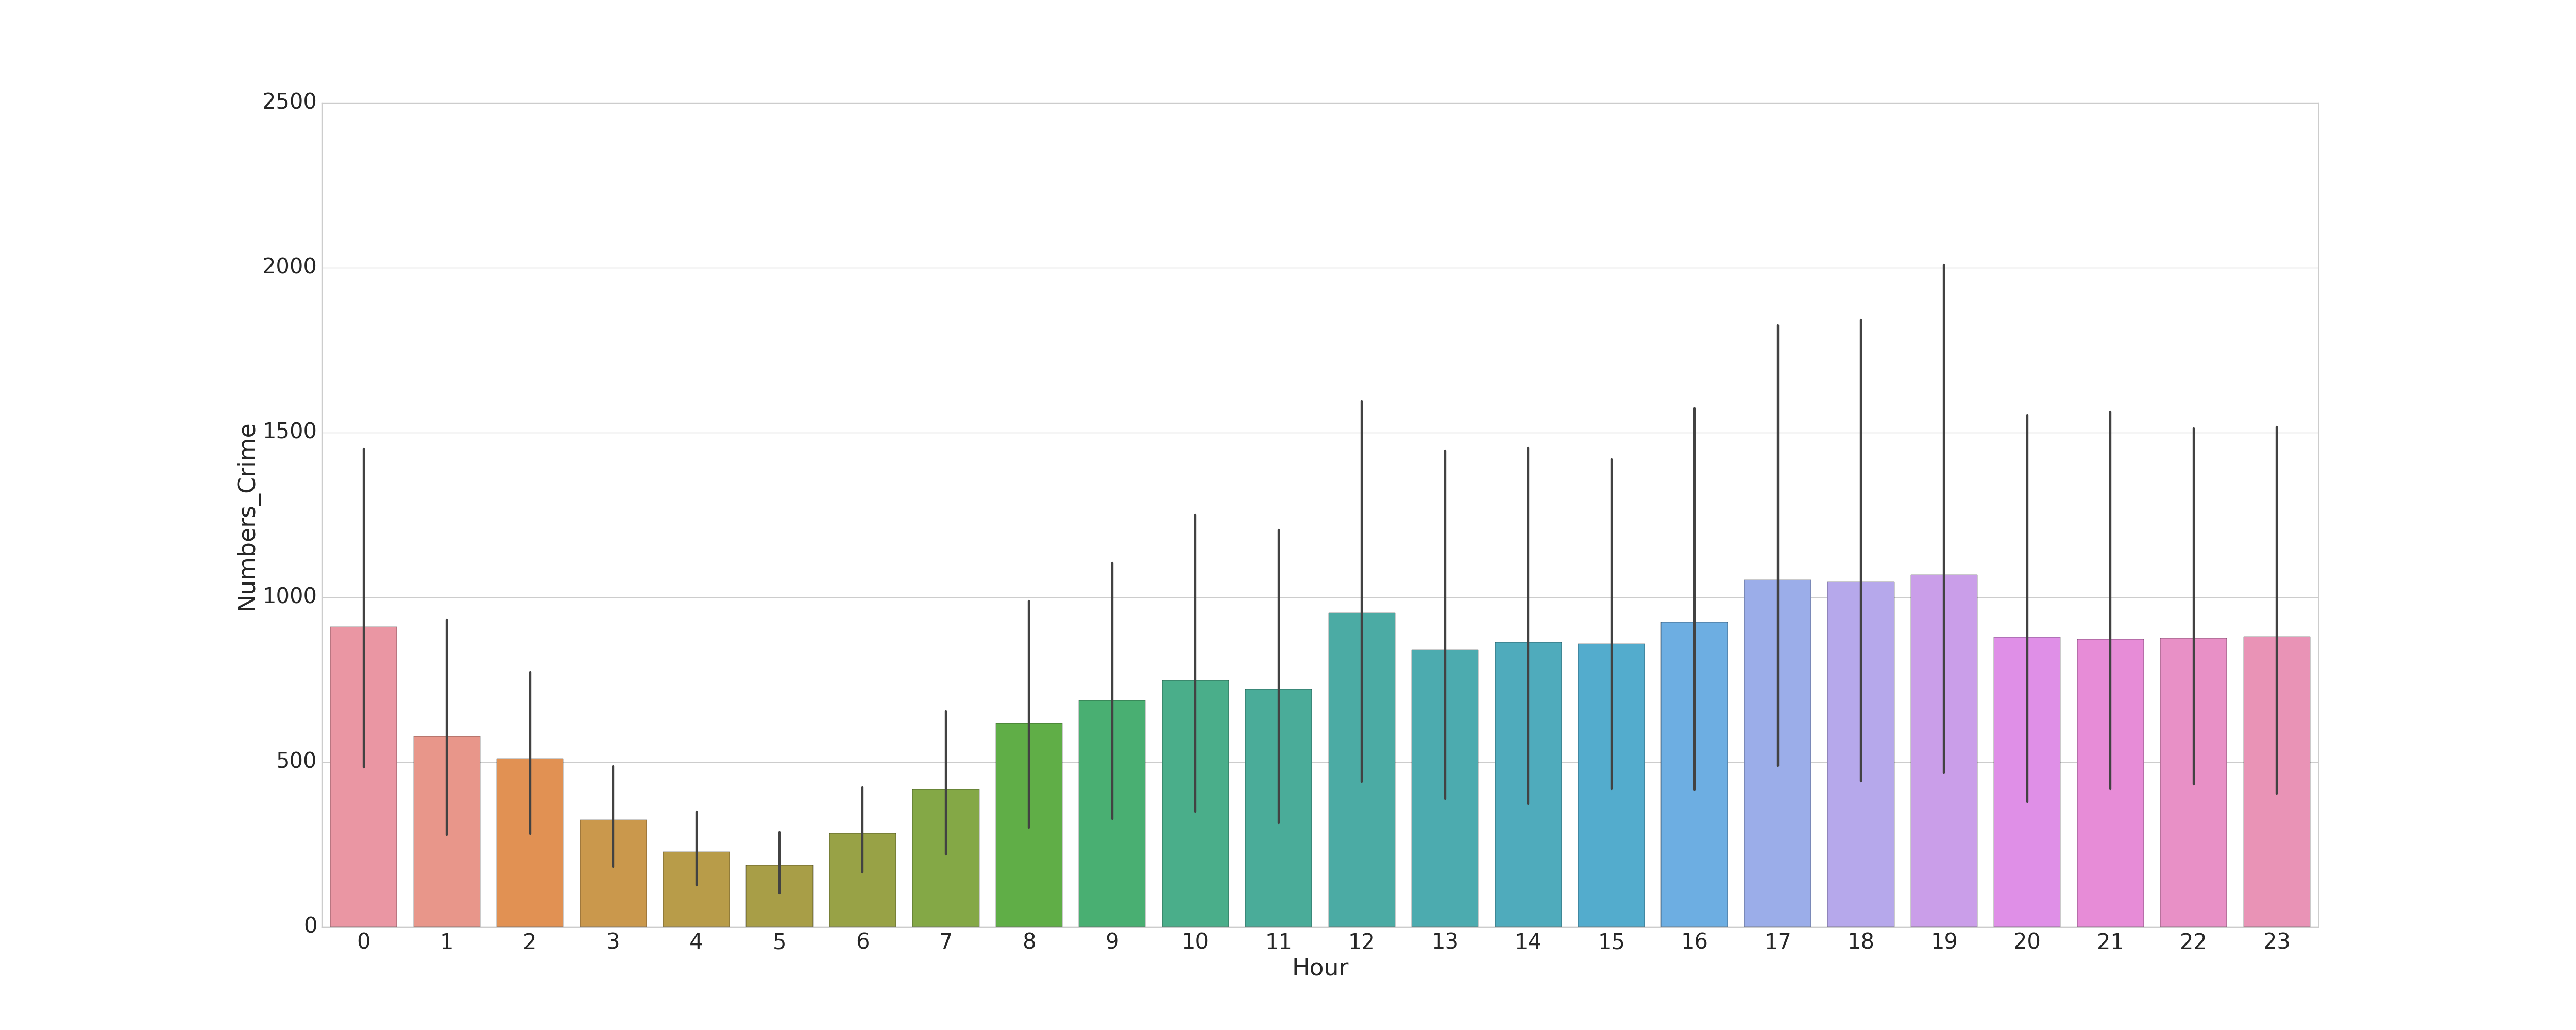

In [44]:
fig = plt.figure(figsize=(50,20))
sb.set(font_scale=3, style = "whitegrid")
sb.barplot(x= "Hour", y = "Numbers_Crime",  data = df_crime_danger_cat)
plt.legend(loc='upper left')
display(fig)

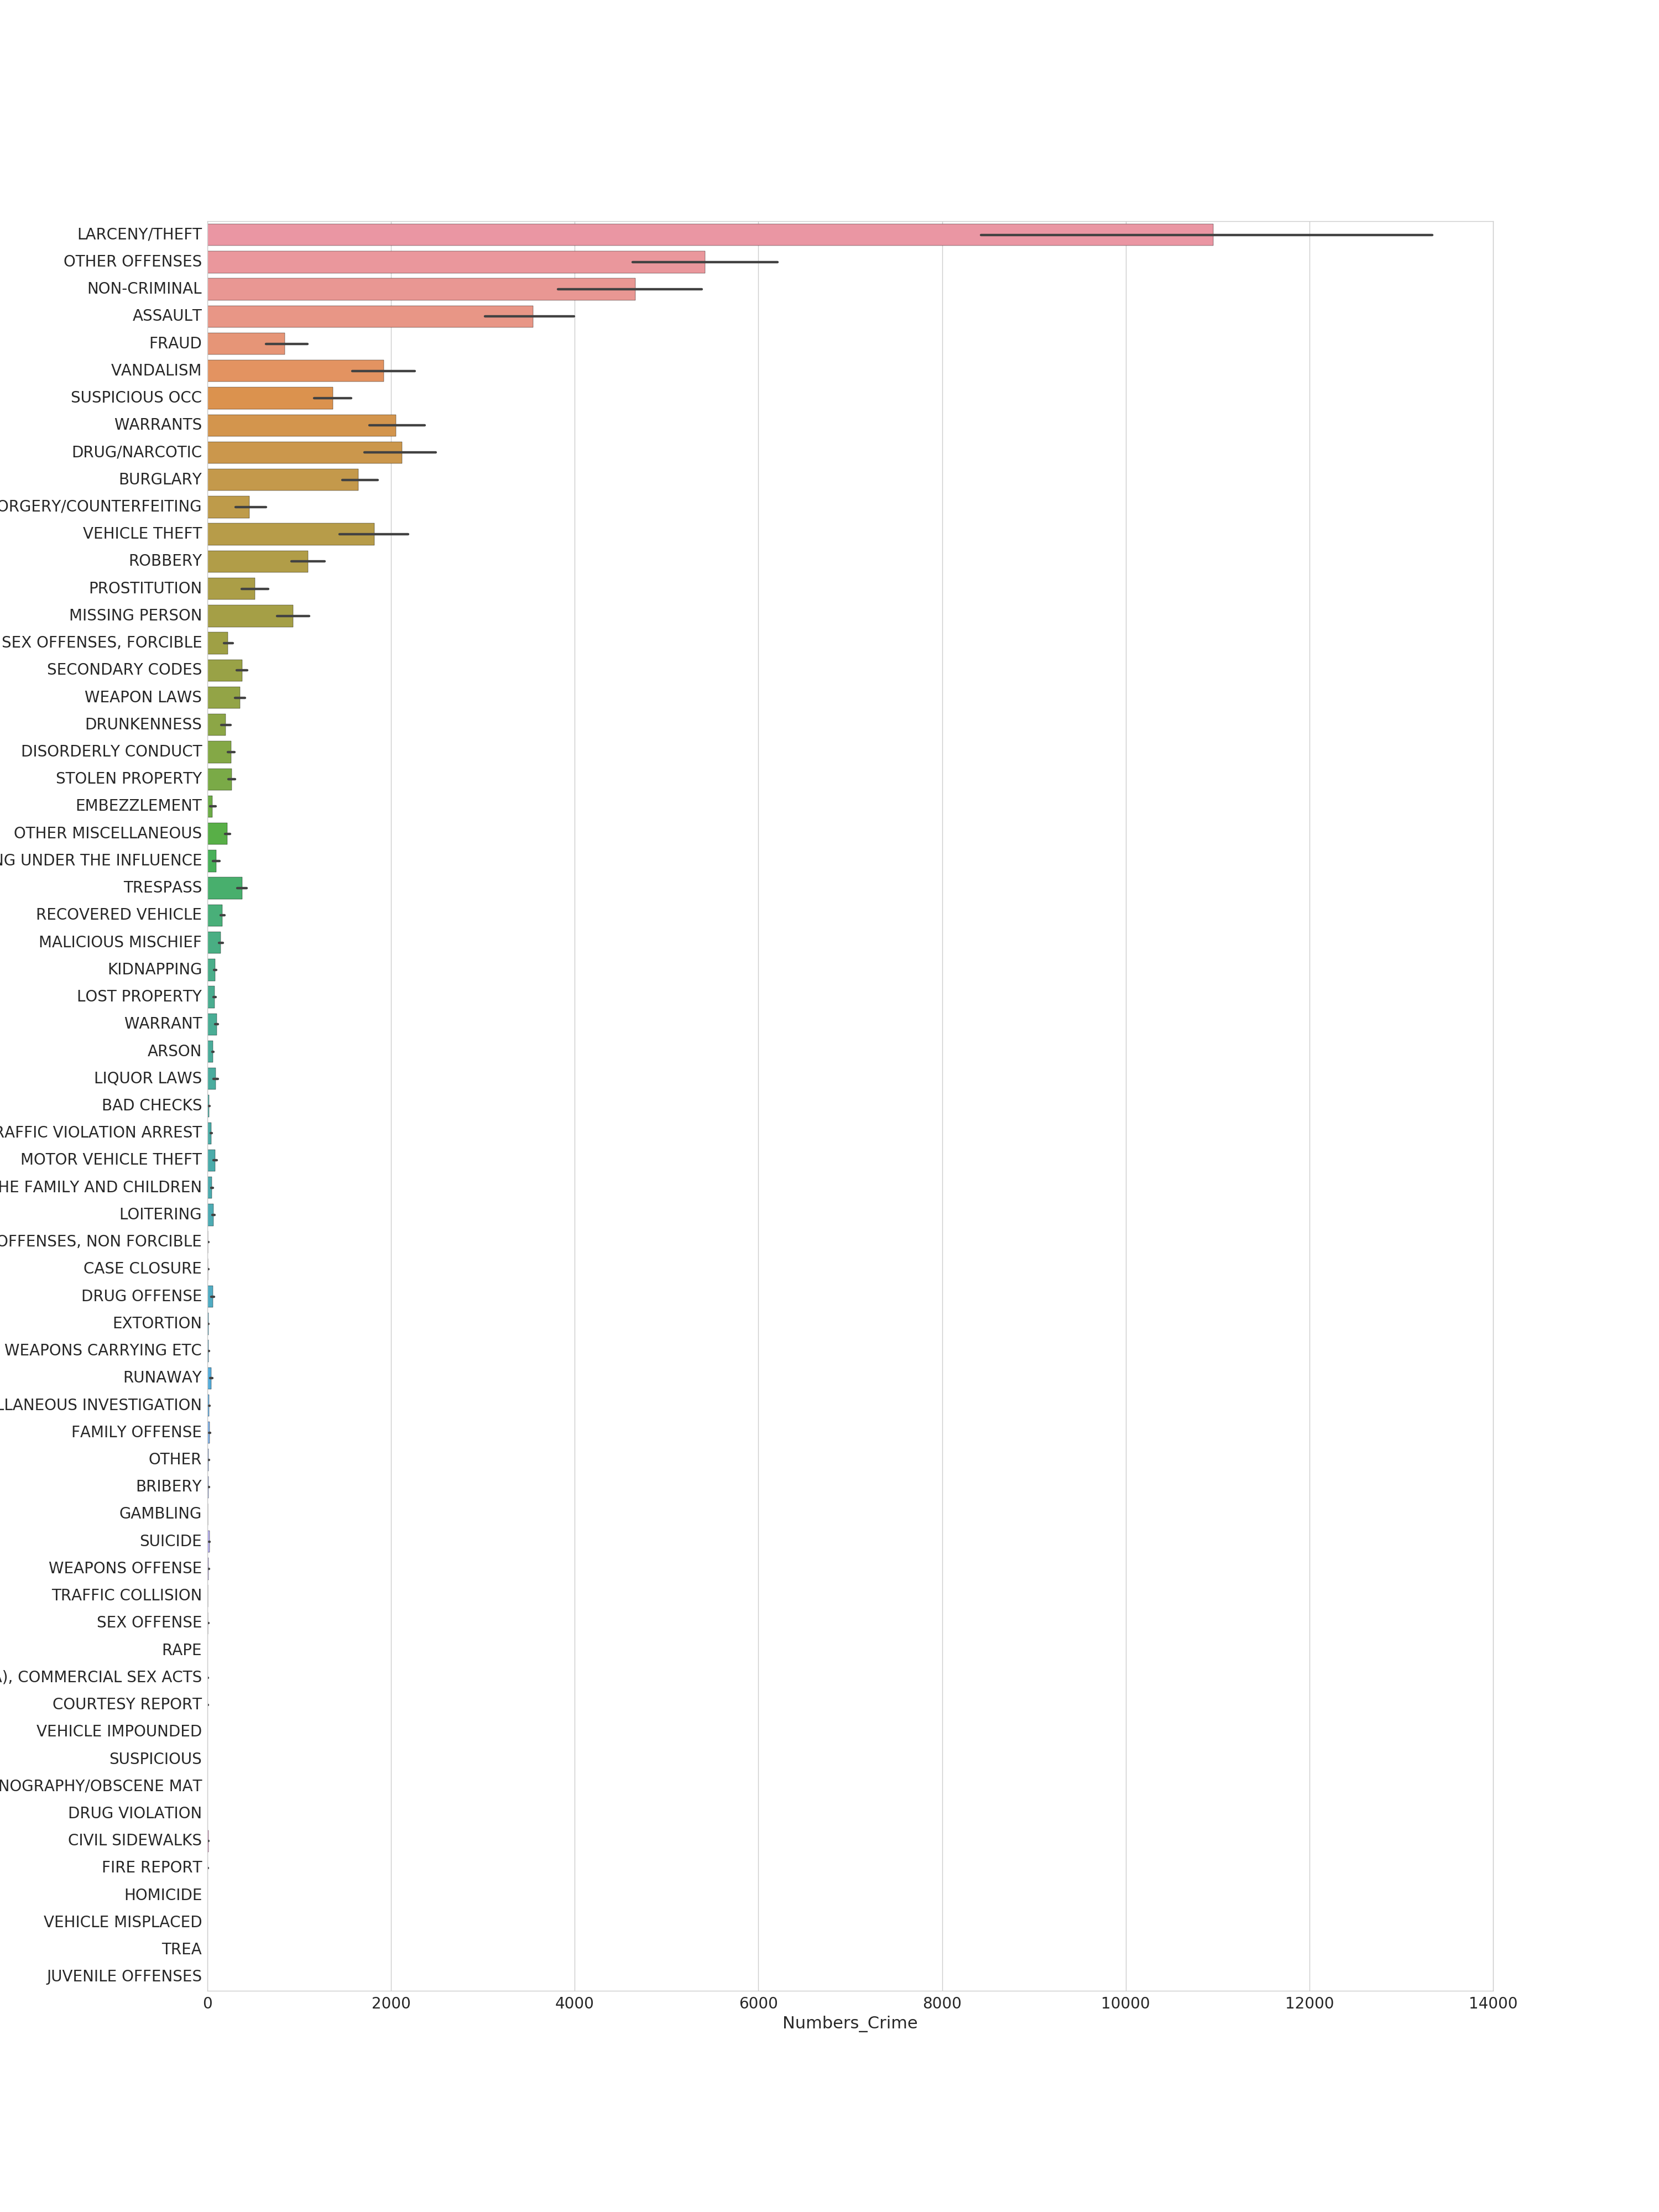

In [45]:
fig = plt.figure(figsize=(30,40))
sb.set(font_scale=2, style = "whitegrid")
sb.barplot(x= "Numbers_Crime", y = "Category", data = df_crime_danger_cat)
plt.legend(loc='upper left')
plt.xticks(rotation = 0)
display(fig)

##### give your advice to distribute the police based on your analysis results

We should enhance more police resources after 8 a.m. because the number of crimes surge up after that time and decrease again after 1 a.m.. Also, police resources should be in the maximun during lunch time and dinner time because it is having highest number of crimes during theses two periods and "THEFTS" and "OTHER OFFENSE" is the most frequent crime during these three district. The police resources should be configured according to of the "THEFTS" and "OTHER OFFENSE" more.

#### Q7 question (OLAP)
For different category of crime, find the percentage of resulition. Based on the output, give your hints to adjust the policy.

In [48]:
df_crime_percent_cat = spark.sql("SELECT Category, COUNT(*) AS Numbers_Crime \
                                  FROM sf_crime \
                                  GROUP BY Category")


df_crime_percent_cat_new = df_crime_percent_cat.toPandas()
sum_crime = df_crime_percent_cat_new["Numbers_Crime"].sum()
df_crime_percent_cat_new = df_crime_percent_cat_new.sort_values(by = ["Numbers_Crime"], ascending = False)
df_crime_percent_cat_new["Crime_Percent"] = df_crime_percent_cat_new["Numbers_Crime"].map(lambda x: str(round((float(x)/sum_crime)*100,2))+" %")
df_crime_percent_cat_new.drop(["Numbers_Crime"], axis = 1)

Out[ 103 ]: 
 Category Crime_Percent
58 LARCENY/THEFT 22.22 %
8 OTHER OFFENSES 13.11 %
55 NON-CRIMINAL 10.49 %
20 ASSAULT 8.62 %
56 VEHICLE THEFT 5.35 %
50 DRUG/NARCOTIC 5.05 %
49 VANDALISM 4.91 %
12 WARRANTS 4.28 %
60 BURGLARY 4.17 %
33 SUSPICIOUS OCC 3.52 %
6 MISSING PERSON 2.94 %
34 ROBBERY 2.52 %
0 FRAUD 1.94 %
4 SECONDARY CODES 1.09 %
14 FORGERY/COUNTERFEITING 1.0 %
29 WEAPON LAWS 0.94 %
54 TRESPASS 0.82 %
41 PROSTITUTION 0.72 %
57 STOLEN PROPERTY 0.54 %
46 DISORDERLY CONDUCT 0.54 %
2 OTHER MISCELLANEOUS 0.53 %
48 RECOVERED VEHICLE 0.51 %
36 SEX OFFENSES, FORCIBLE 0.5 %
22 DRUNKENNESS 0.42 %
40 MALICIOUS MISCHIEF 0.37 %
15 WARRANT 0.25 %
9 DRIVING UNDER THE INFLUENCE 0.24 %
23 MOTOR VEHICLE THEFT 0.23 %
59 KIDNAPPING 0.23 %
21 LOST PROPERTY 0.2 %
.. ... ...
42 EMBEZZLEMENT 0.13 %
31 LOITERING 0.1 %
19 TRAFFIC VIOLATION ARREST 0.09 %
52 FAMILY OFFENSE 0.06 %
1 SUICIDE 0.06 %
32 MISCELLANEOUS INVESTIGATION 0.06 %
39 OTHER 0.04 %
45 BAD CHECKS 0.04 %
63 WEAPONS CARRYING ETC 0.04 %
43 WEAPONS OFFENSE 0.03 %
18 BRIBERY 0.03 %
26 EXTORTION 0.03 %
62 CASE CLOSURE 0.03 %
5 CIVIL SIDEWALKS 0.02 %
53 SEX OFFENSE 0.02 %
64 SEX OFFENSES, NON FORCIBLE 0.02 %
37 COURTESY REPORT 0.02 %
16 GAMBLING 0.02 %
25 TRAFFIC COLLISION 0.01 %
30 JUVENILE OFFENSES 0.01 %
11 FIRE REPORT 0.01 %
38 VEHICLE IMPOUNDED 0.0 %
17 HUMAN TRAFFICKING (A), COMMERCIAL SEX ACTS 0.0 %
27 VEHICLE MISPLACED 0.0 %
51 PORNOGRAPHY/OBSCENE MAT 0.0 %
7 DRUG VIOLATION 0.0 %
44 RAPE 0.0 %
61 SUSPICIOUS 0.0 %
35 HOMICIDE 0.0 %
28 TREA 0.0 %

[65 rows x 2 columns]

##### give your advice to distribute the police based on your analysis results

The police resources should be configured according to of the "THEFTS", "OTHER OFFENSE", and "ASSAULT" more. Also, there should be a penalty or other policy of "NON-CRIMINAL" so that to decrease the percentage of "NON-CRIMINAL" and waste the government resources.

#### Q8 question (Apply Spark ML clustering for spatial data analysis)
Extra: visualize the spatial distribution of crimes and run a kmeans clustering algorithm (please use Spark ML kmeans)  
You can refer Spark ML Kmeans a example: https://spark.apache.org/docs/latest/ml-clustering.html#k-means

In [51]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

df_kmeans = spark.sql("SELECT X, Y FROM sf_crime")
assembler = VectorAssembler(inputCols = df_kmeans.columns, outputCol="features")
assembled = assembler.transform(df_kmeans)

scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scaler_model = scaler.fit(assembled)
assembled = scaler_model.transform(assembled)

In [52]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

cost = np.zeros(10)
for k in range(2,10):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("scaledFeatures")
    model = kmeans.fit(assembled.sample(False,0.1, seed=42))
    cost[k] = model.computeCost(assembled) # requires Spark 2.0 or later

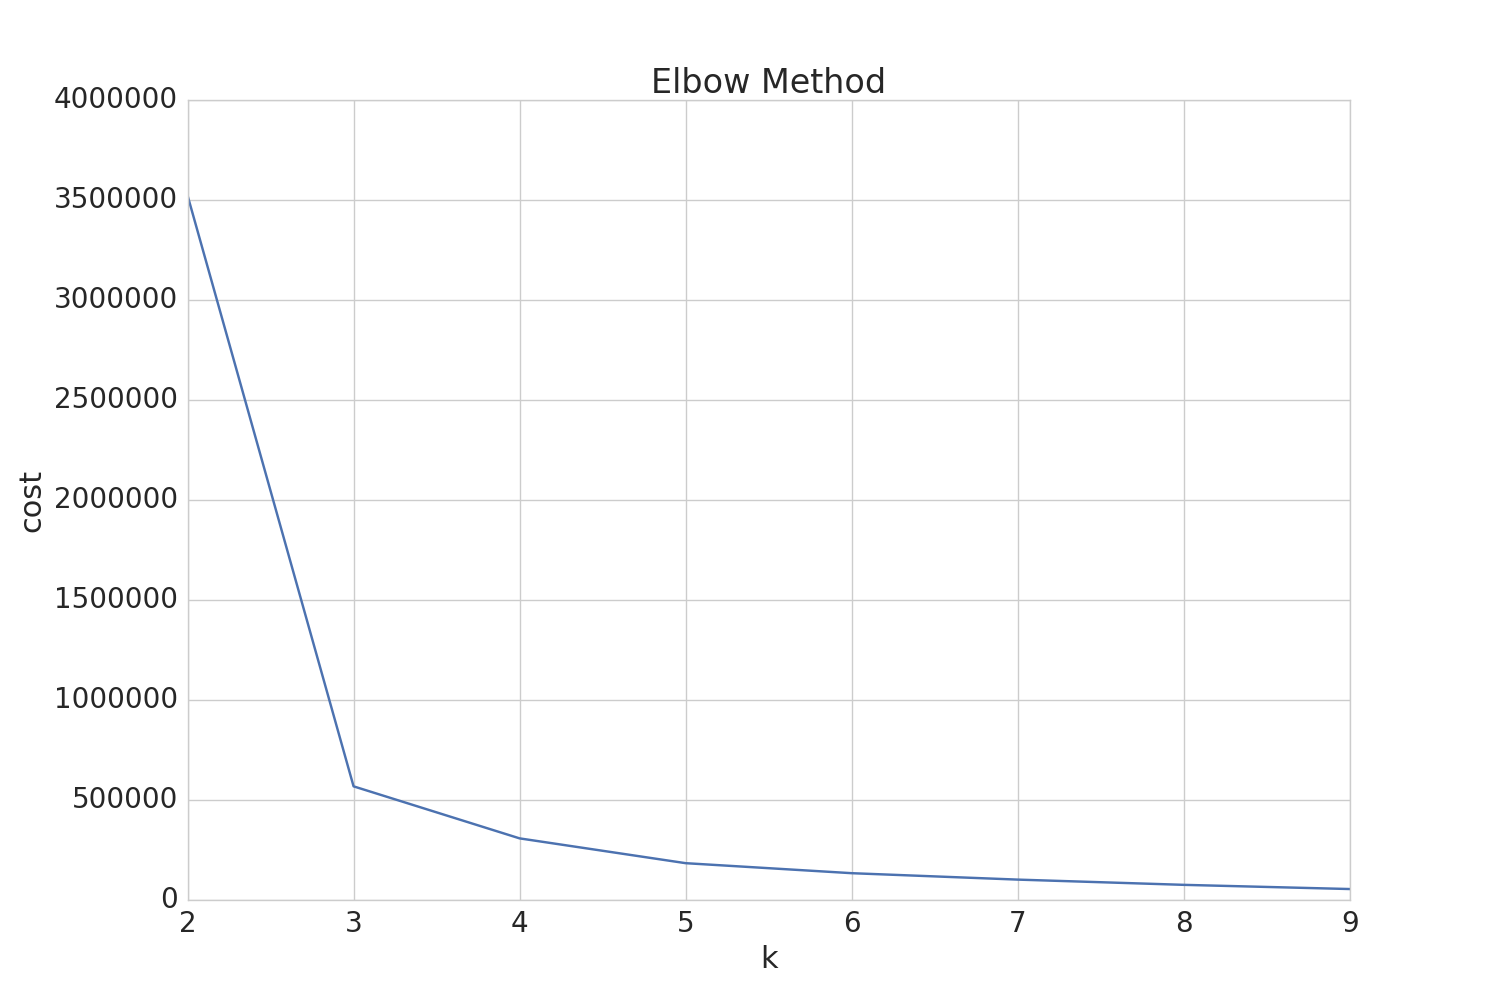

In [53]:
# according to the cost versus number of clusters, I chose k = 3
fig, ax = plt.subplots(1,1, figsize =(15,10))
ax.plot(range(2,10),cost[2:10])
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.set_title("Elbow Method")
display(fig)

In [54]:
# Trains a k-means model.
kmeans = KMeans().setK(3).setSeed(1)
model = kmeans.fit(assembled)

# Make predictions
predictions = model.transform(assembled)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Silhouette with squared euclidean distance = 0.6655980664633159
Cluster Centers: 
[-122.46015524 37.74648537]
[-120.5 90. ]
[-122.41250884 37.77349549]

In [55]:
predictions.select("X","Y","prediction").show(truncate = False)

+-----------+---------+----------+
X |Y |prediction|
+-----------+---------+----------+
-122.421585|37.7617 |2 |
-122.414406|37.78419 |2 |
-122.414406|37.78419 |2 |
-122.414406|37.78419 |2 |
-122.43112 |37.80047 |2 |
-122.45178 |37.787086|0 |
-122.374016|37.729202|2 |
-122.374016|37.729202|2 |
-122.40657 |37.787807|2 |
-122.4173 |37.78626 |2 |
-122.41335 |37.769073|2 |
-122.41335 |37.769073|2 |
-122.41335 |37.769073|2 |
-122.41335 |37.769073|2 |
-122.4322 |37.76511 |2 |
-122.42228 |37.781754|2 |
-122.42228 |37.781754|2 |
-122.38794 |37.74226 |2 |
-122.45864 |37.7672 |0 |
-122.38978 |37.735226|2 |
+-----------+---------+----------+
only showing top 20 rows

In [56]:
predictions_pd = predictions.toPandas()
fig = plt.figure(figsize=(10,10))
sb.scatterplot("X", "Y")
plt.legend(loc='upper left')
display(fig)